# Tutorial x : Training Spiking Neural Networks using BPTT

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**

**Content creators**: Ugurcan Cakal, Philipp Weidel

**Content reviewers**: Hannah Bos, Dylan Muir

This tutorial demonstrates using Rockpool and a torch-based single leaky integrate and fire neuron layer to perform gradient descent training of all network parameters. The spiking nerual network is trained on a representative toy task as it is easy but still requires temporal memory.

## Tutorial Objectives
**Estimated timing**: 30 minutes

In this tutorial, we will explain:

* What a surrogate gradient is and why it's necessary?
* How to train spiking neural networks using troch gradient mechanics to update weight and time constant parameters

### TODOS
* Use tonic instead of torch dataset or do not use dataset at all.
    * It might be better to introduce if it helps Hannah
* Explain in seconds instead of in timesteps
* Maybe explain BPTT a bit
* Maybe explain TSEvent and TSContinuous a bit
* Try with StepPWL instead of PeriodicExponential
* Use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)
* Explain network, LinearTorch, LIFTorch and Sequential combinator
* A utility function to plot all Vmem, Isyn and etc.
* Tex formatting to figures like Vmem
* Figure titles
* Slightly explain loss function, activation function, gradient descent, adam optimizer and training loop
* Try to add output linear
* If not enough, go add two or more neurons, increase model complexity and do it again
* add bound loss
* what happens with negative weights and positive weights?
* work on input dimensionality

### Interaction
* Changing delay
* What if we want to train time constants?
    * Add dt bounds >0
* What if we already know some constraints?
    * Add lower and upper bounds


## Setup

First we need to download and build necessary python libraries

! CHECK THIS OUT. MAY NOT BE NECESSARY AT ALL

In [1]:
# !git clone https://github.com/synsense/rockpool.git
# %cd rockpool
# !git checkout dev/dynapse_support
# !pip install .[all]
# !pip install tonic

In [2]:
# Rockpool Imports
from rockpool.timeseries import TSEvent, TSContinuous
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.nn.modules.torch.lif_torch import PeriodicExponential
from typing import Dict

# Torch Imports
import torch
from torch import nn
from torch.optim import Adam

# Numpy
import numpy as np
from tqdm import tqdm

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

/home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/nn/modules/__init__.py:45: UserWarning: Sinabs modules not available: 'Slayer' backend not found. Modules that rely on Sinabs-Slayer will not be available.
  warnings.warn(f"Sinabs modules not available: {err}")


Could not import package: No module named 'iaf_nest'


### Plotting Utilities

In [3]:
def plot_LIF_record(
    rec: Dict[str, torch.tensor],
    plot_Vmem: bool = True,
    plot_Isyn: bool = True,
    plot_spikes: bool = True,
    plot_Irec: bool = False,
    plot_U: bool = True,
    dt: float = 1e-3,
) -> None:
    _to_numpy = lambda _tensor: _tensor.detach().numpy().flatten()

    if plot_Irec:
        Irec_ts = TSContinuous.from_clocked(
            _to_numpy(rec["irec"]), dt=dt, name="$I_{rec}$"
        )
        plt.figure()
        plt.ylabel("Current")
        Irec_ts.plot()

    if plot_Isyn:
        Isyn_ts = TSContinuous.from_clocked(
            _to_numpy(rec["isyn"]), dt=dt, name="$I_{syn}$"
        )
        plt.figure()
        plt.ylabel("Current")
        Isyn_ts.plot()

    if plot_Vmem:
        Vmem_ts = TSContinuous.from_clocked(
            _to_numpy(rec["vmem"]), dt=dt, name="$V_{mem}$"
        )
        plt.figure()
        plt.ylabel("Voltage")
        Vmem_ts.plot()

    if plot_U:
        U_ts = TSContinuous.from_clocked(
            _to_numpy(rec["U"]), dt=dt, name="Surrogate $U$"
        )
        plt.figure()
        plt.ylabel("Voltage")
        U_ts.plot()   

    if plot_spikes:
        spikes_ts = TSEvent.from_raster(_to_numpy(rec["spikes"]), dt=dt, name="Output Spikes")
        plt.figure()
        spikes_ts.plot()

### Data Generation

In [4]:
def one_spike_sample(
    t_spike: float = 10e-3,
    duration: float = 100e-3,
    dt: float = 1e-3,
) -> torch.tensor:

    _n = lambda t: int(np.around(t / dt))
    _sample = torch.zeros((1, _n(duration), 1))
    _sample[0, _n(t_spike), 0] = 1

    return _sample

def constant_rate_spike_train(
    duration: float,
    rate: float,
    dt: float = 1e-3,
) -> torch.tensor:
    """

    :param duration: The simulation duration in seconds
    :type duration: float
    :param rate: The spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: The time step for the forward-Euler ODE solver, defaults to 1e-3
    :type dt: float, optional
    :return: constant rate discrete spike train
    :rtype: torch.tensor

    """
    _n = lambda _t, _s: int(np.around(_t / _s))
    steps = _n(duration, dt)
    _idx = _n(steps, rate)
    
    _sample = torch.zeros((1, steps, 1))
    _sample[0, range(_idx, steps, _idx), 0] = 1    

    return _sample

def poisson_spike_train(
    duration: float,
    rate: float,
    dt: float = 1e-3,
) -> torch.tensor:
    """
    random_spike_train generate a Poisson frozen random spike train and

    :param duration: The simulation duration in seconds
    :type duration: float
    :param rate: The spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: The time step for the forward-Euler ODE solver, defaults to 1e-3
    :type dt: float, optional
    :raises ValueError: No spike generated due to low firing rate or very short simulation time]
    :return: randomly generated discrete spike train
    :rtype: torch.tensor

    """

    steps = int(np.round(duration / dt))
    input_sp_raster = np.random.poisson(rate * dt, (1, steps, 1))
    if not any(input_sp_raster.flatten()):
        raise ValueError(
            "No spike generated at all due to low firing rate or short simulation time duration!"
        )
    input_sp_ts = torch.tensor(input_sp_raster, dtype=torch.float)
    return input_sp_ts

In [5]:
from rockpool.nn.modules.torch.torch_module import TorchModule

class RateReadout(TorchModule):
    def __init__(
        self,
        shape: tuple,
        dt: float = 1e-3,
        *args,
        **kwargs,
    ) -> None:
        """
        Initialise a LinearTorch layer

        Args:
            shape (tuple): The shape of this layer ``(Nin, Nout)``
        """
        # - Initialise superclass
        super().__init__(shape=shape, *args, **kwargs)

        # - Check arguments
        if len(self.shape) != 2:
            raise ValueError(
                "`shape` must specify input and output sizes for RateReadout."
            )

        self.dt = dt

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        input, _ = self._auto_batch(input)

        n_batch, n_timesteps, n_channel = input.shape
        rate = (torch.sum(input) / (n_timesteps * self.dt))
        return rate

## Section 1: Rockpool Modules

In [6]:
dt = 1e-3

lin_0 = LinearTorch((1, 1), weight = torch.tensor([[.5]]), has_bias=False)
neuron_0 = LIFTorch((1, 1), spike_generation_fn=PeriodicExponential)
readout_0 = RateReadout((1,1), dt=dt)
model_0 = Sequential(lin_0, neuron_0, readout_0)

WARNING    /home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/nn/modules/torch/lif_torch.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_float_tensor = lambda x: torch.tensor(x).float()
 [py.warnings]


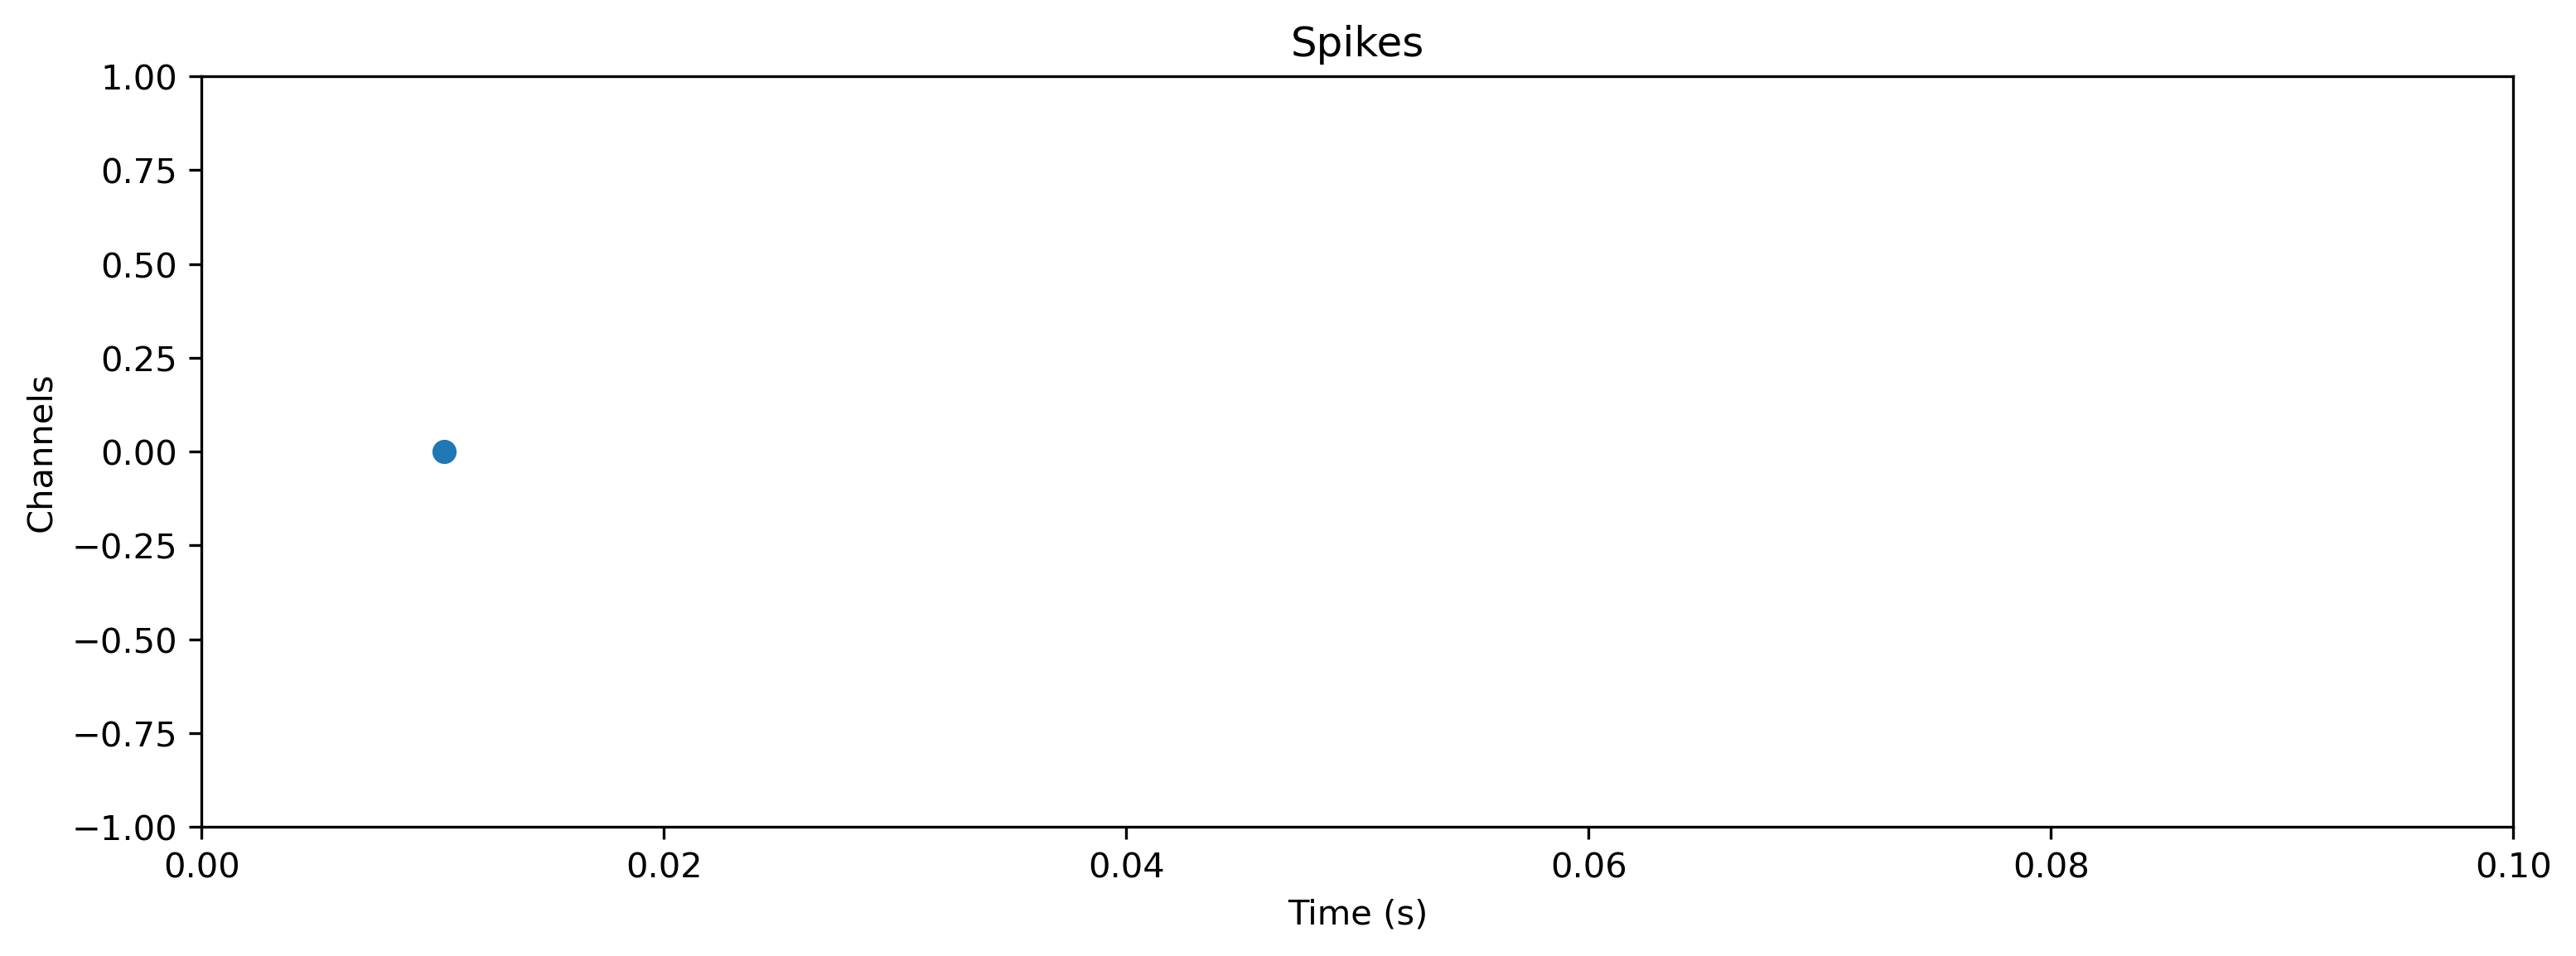

In [7]:
_input = one_spike_sample(t_spike=10e-3, duration=100e-3, dt=dt)
input_ts = TSEvent.from_raster(_input[0], dt=dt, name="Spikes")
input_ts.plot();

In [8]:
model_0.reset_state()
tsOutput_0, new_state_0, record_dict_0 = model_0(_input[0], record = True)

### Model Output

In [9]:
print(type(tsOutput_0))
print(tsOutput_0.shape)
print(tsOutput_0)

<class 'torch.Tensor'>
torch.Size([])
tensor(70., grad_fn=<DivBackward0>)


### Model State

In [10]:
print("State type:", type(new_state_0))
print("State keys:", new_state_0.keys())

State type: <class 'dict'>
State keys: dict_keys(['0_LinearTorch', '1_LIFTorch', '2_RateReadout'])


In [11]:
print("LinearTorch State:", new_state_0["0_LinearTorch"])

LinearTorch State: {}


In [12]:
print("LIFTorch State:", new_state_0["1_LIFTorch"])

LIFTorch State: {'vmem': tensor([0.3228]), 'isyn': tensor([[0.0056]]), 'spikes': tensor([0.])}


In [13]:
print("RateReadout State:", new_state_0["2_RateReadout"])

RateReadout State: {}


### Record Dictionary

In [14]:
print(type(record_dict_0))
print(record_dict_0.keys())

<class 'dict'>
dict_keys(['0_LinearTorch', '0_LinearTorch_output', '1_LIFTorch', '1_LIFTorch_output', '2_RateReadout', '2_RateReadout_output'])


In [15]:
record_dict_0["0_LinearTorch"]

{}

In [16]:
print("LinearTorch Output: ", type(record_dict_0["0_LinearTorch_output"]))

LinearTorch Output:  <class 'torch.Tensor'>


In [17]:
record_dict_0["2_RateReadout"]

{}

In [18]:
print("RateReadout Output: ", record_dict_0["2_RateReadout"])

RateReadout Output:  {}


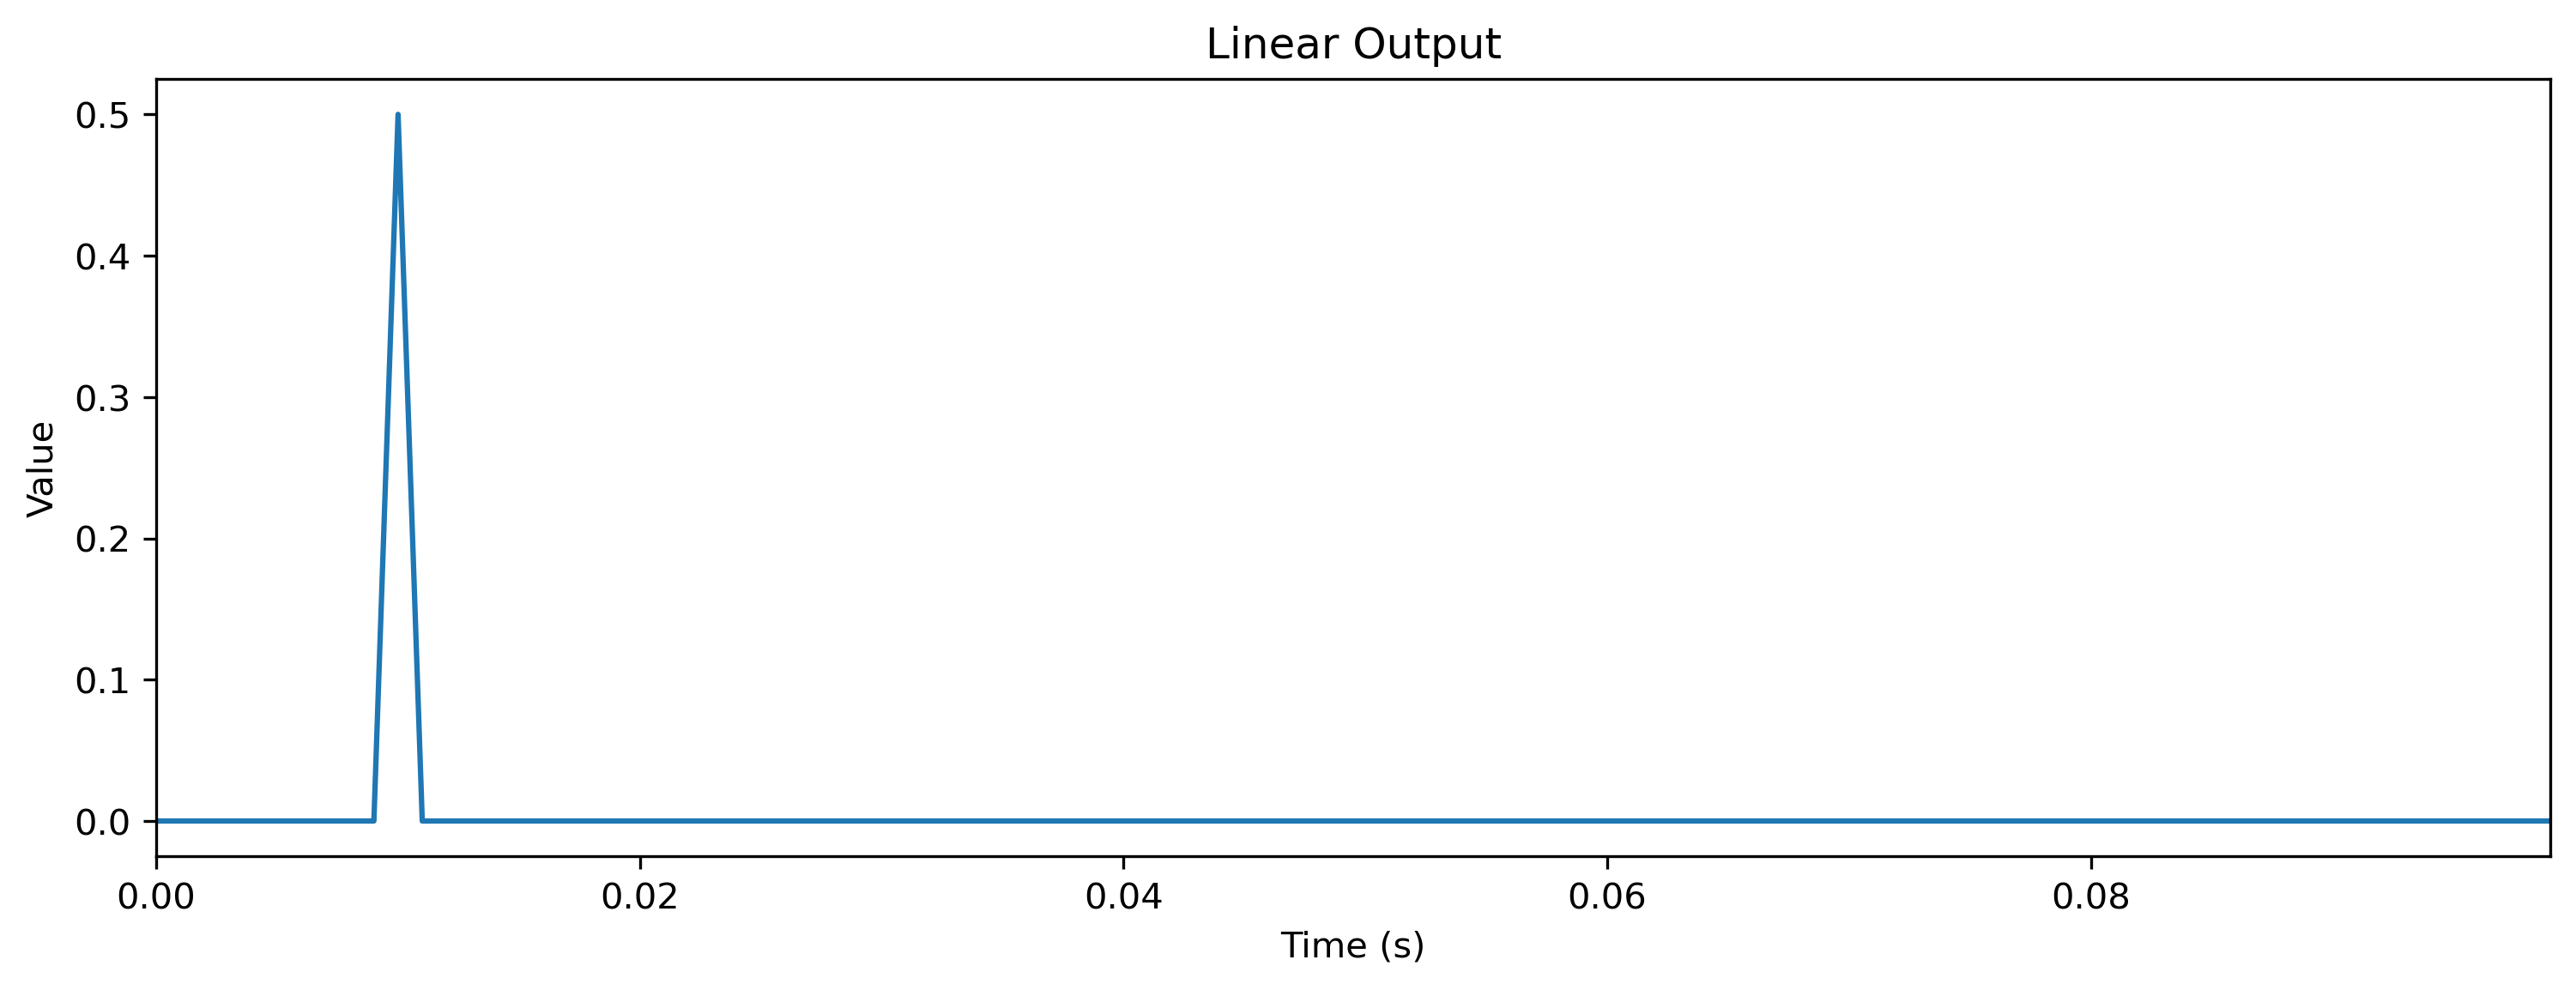

In [19]:
linear_output = TSContinuous.from_clocked(
            record_dict_0["0_LinearTorch_output"].detach().numpy().flatten(), dt=dt, name="Linear Output"
        )
plt.figure()
plt.ylabel("Value")
linear_output.plot();

#### LIFTorch Record

In [20]:
print("LIFTorch Record:", type(record_dict_0["1_LIFTorch"]))
print("LIFTorch Record:", record_dict_0["1_LIFTorch"].keys())

LIFTorch Record: <class 'dict'>
LIFTorch Record: dict_keys(['vmem', 'isyn', 'spikes', 'irec', 'U'])


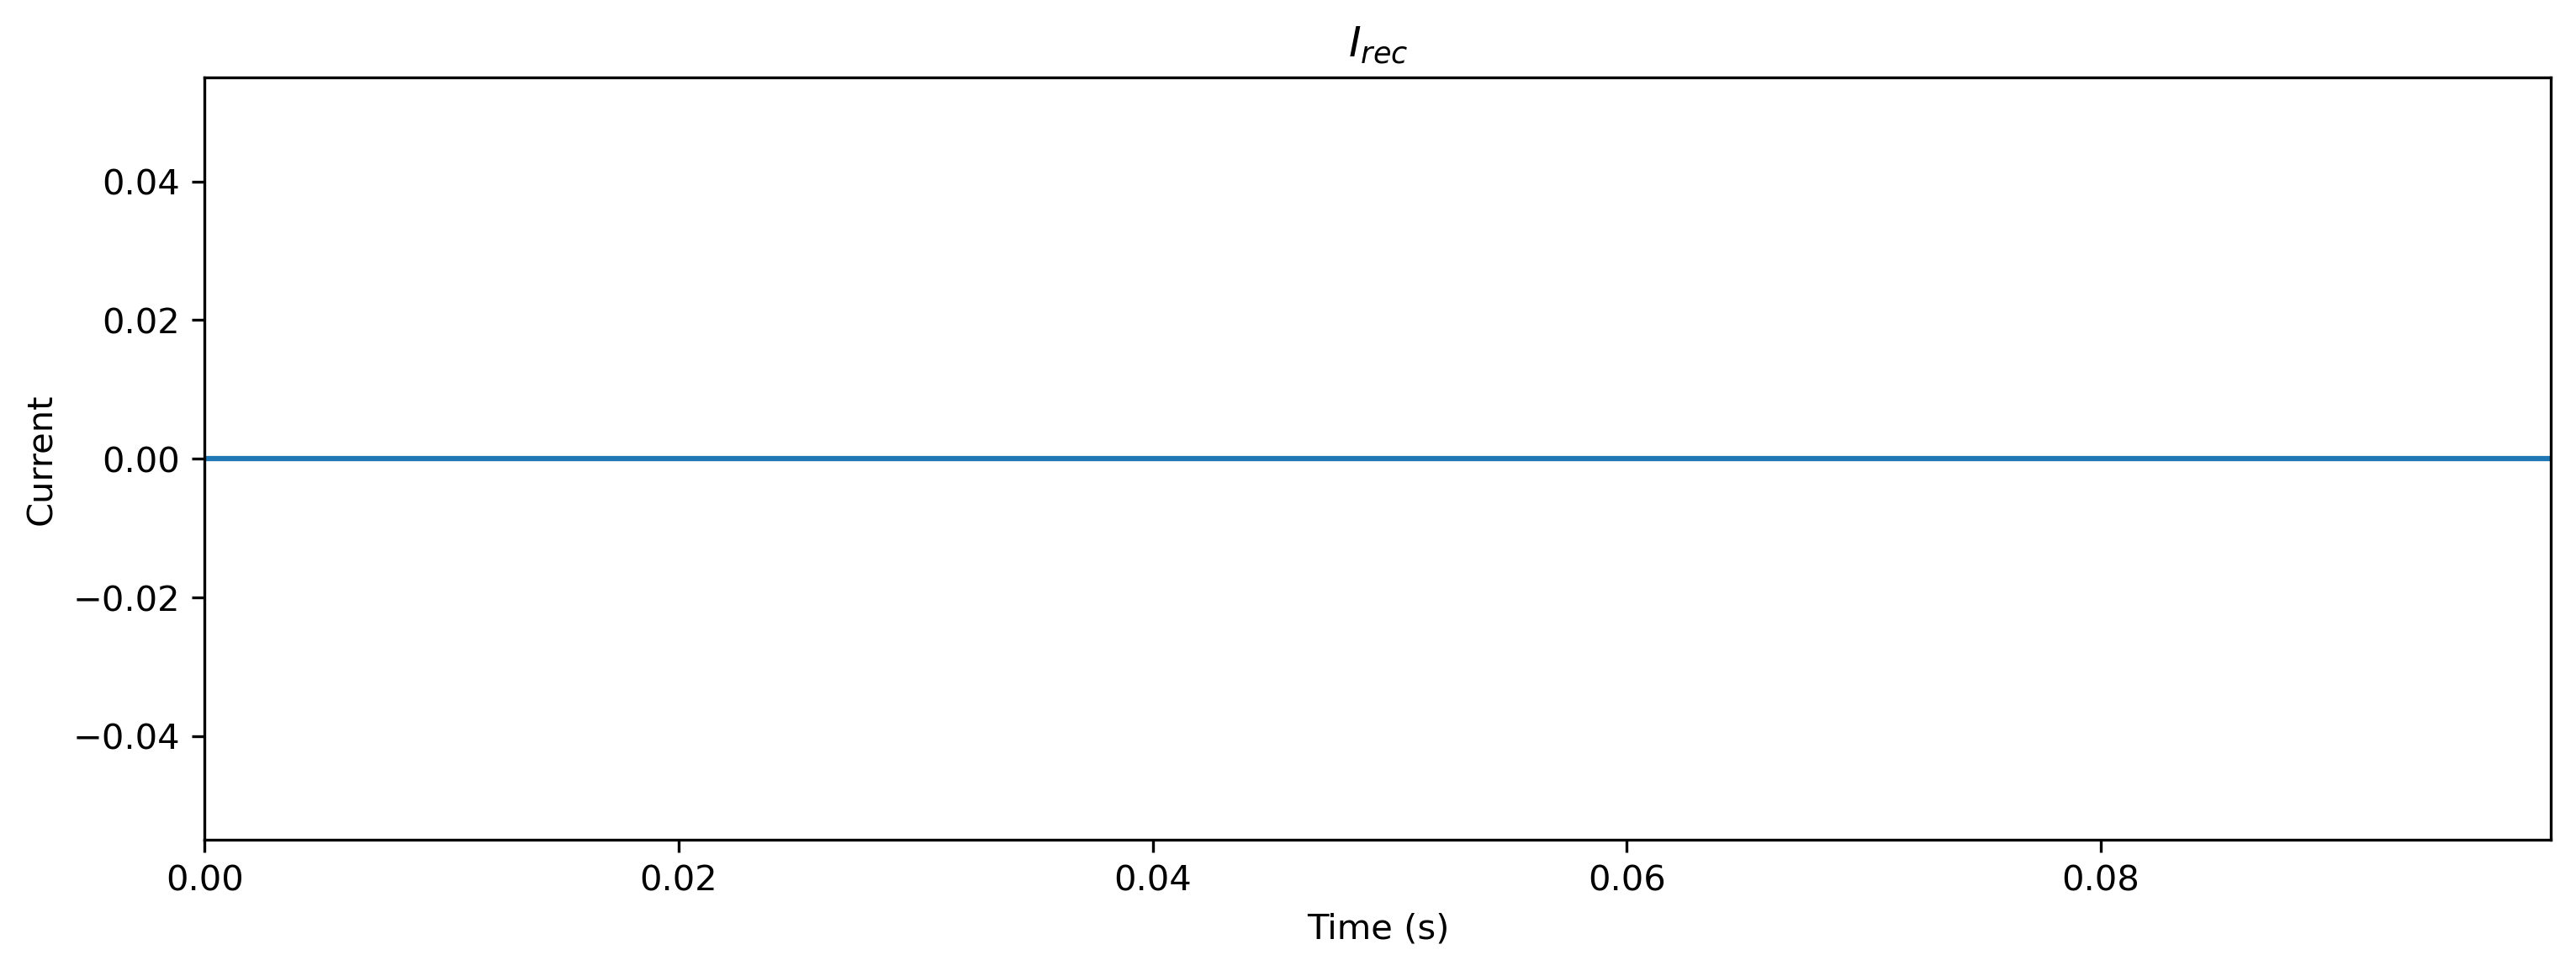

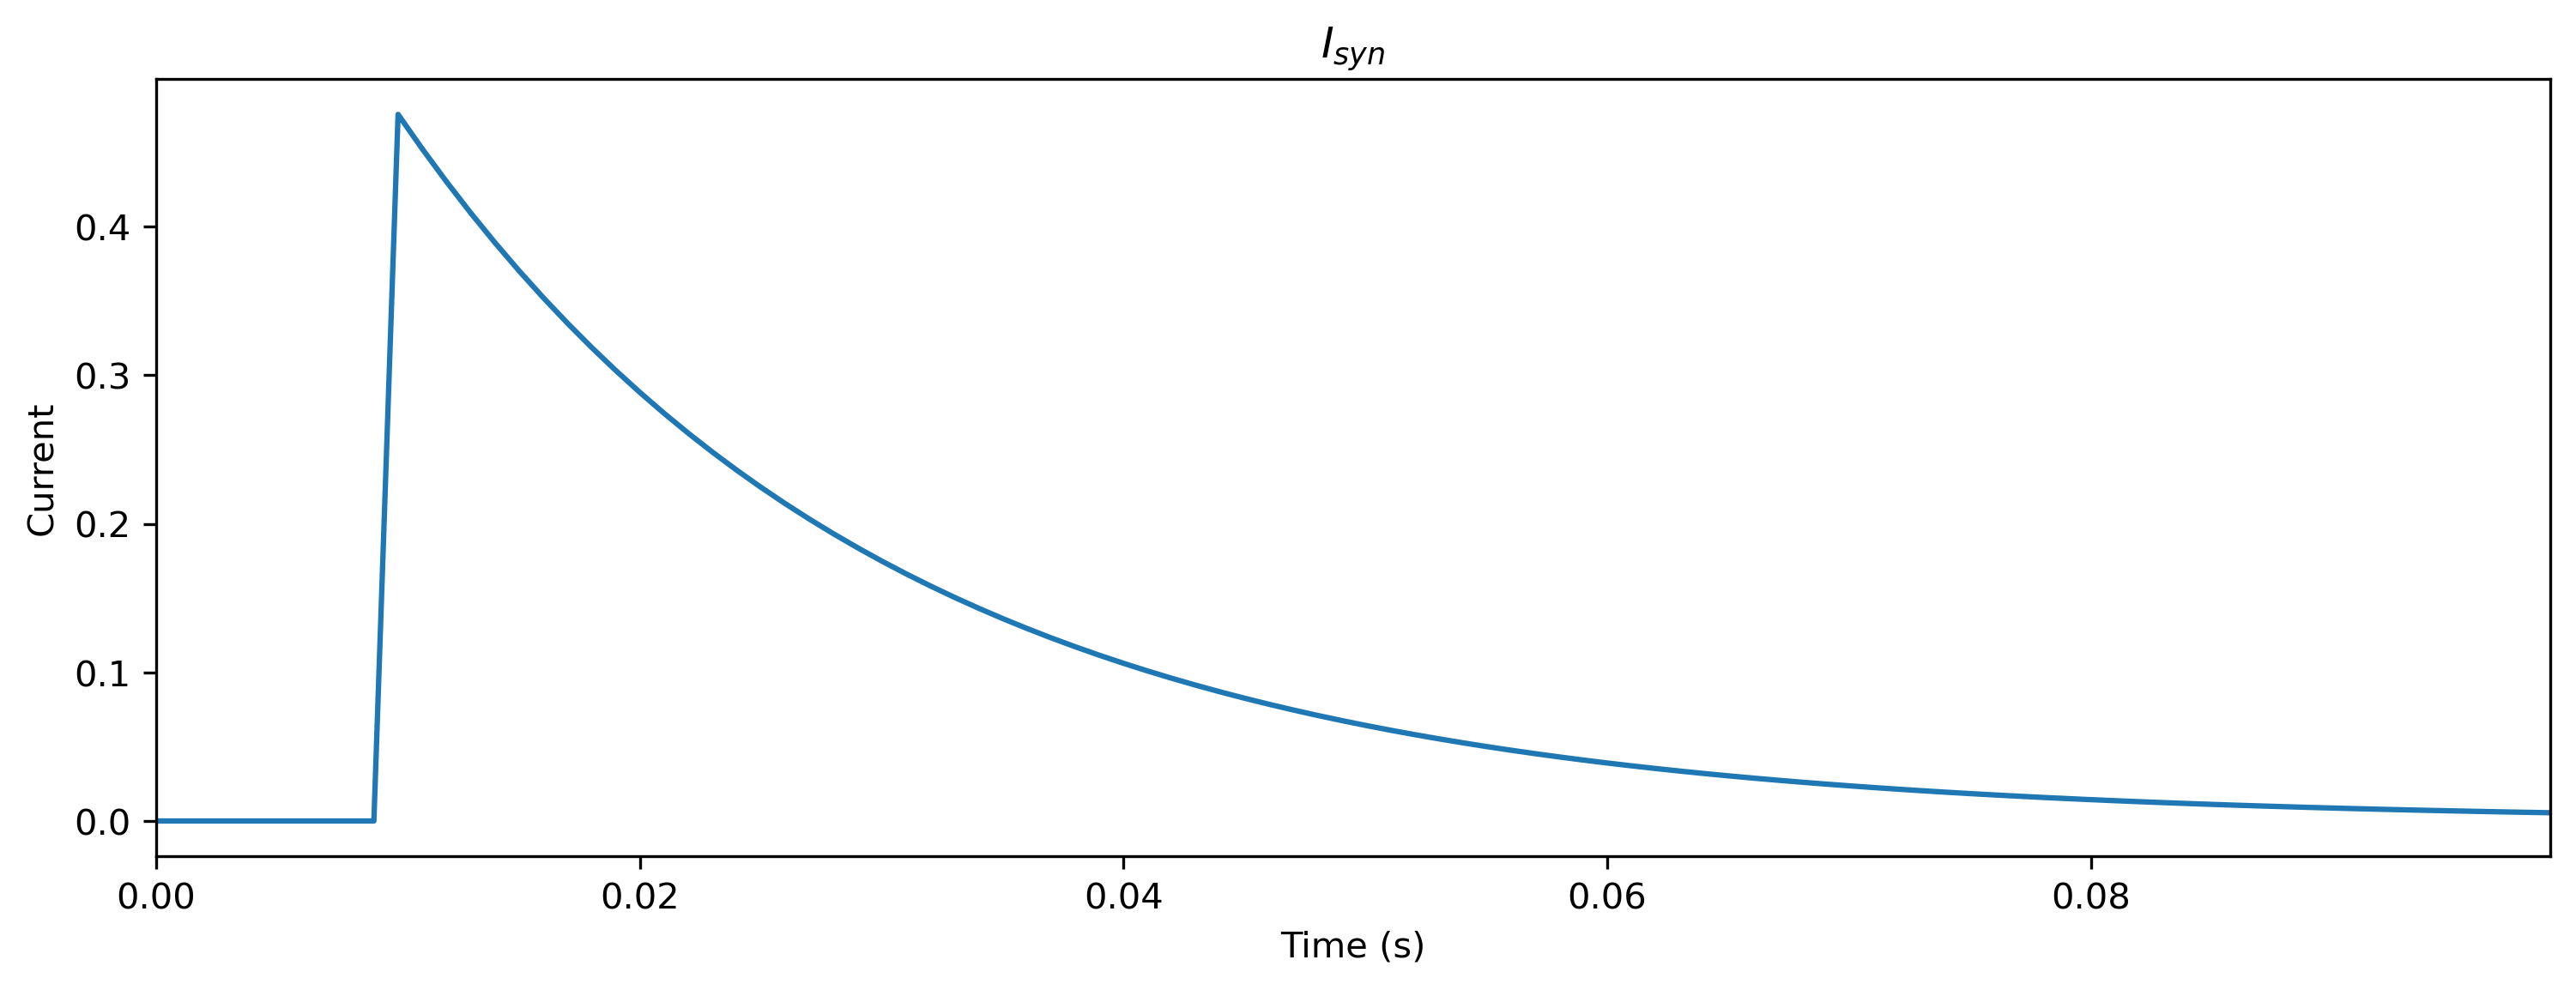

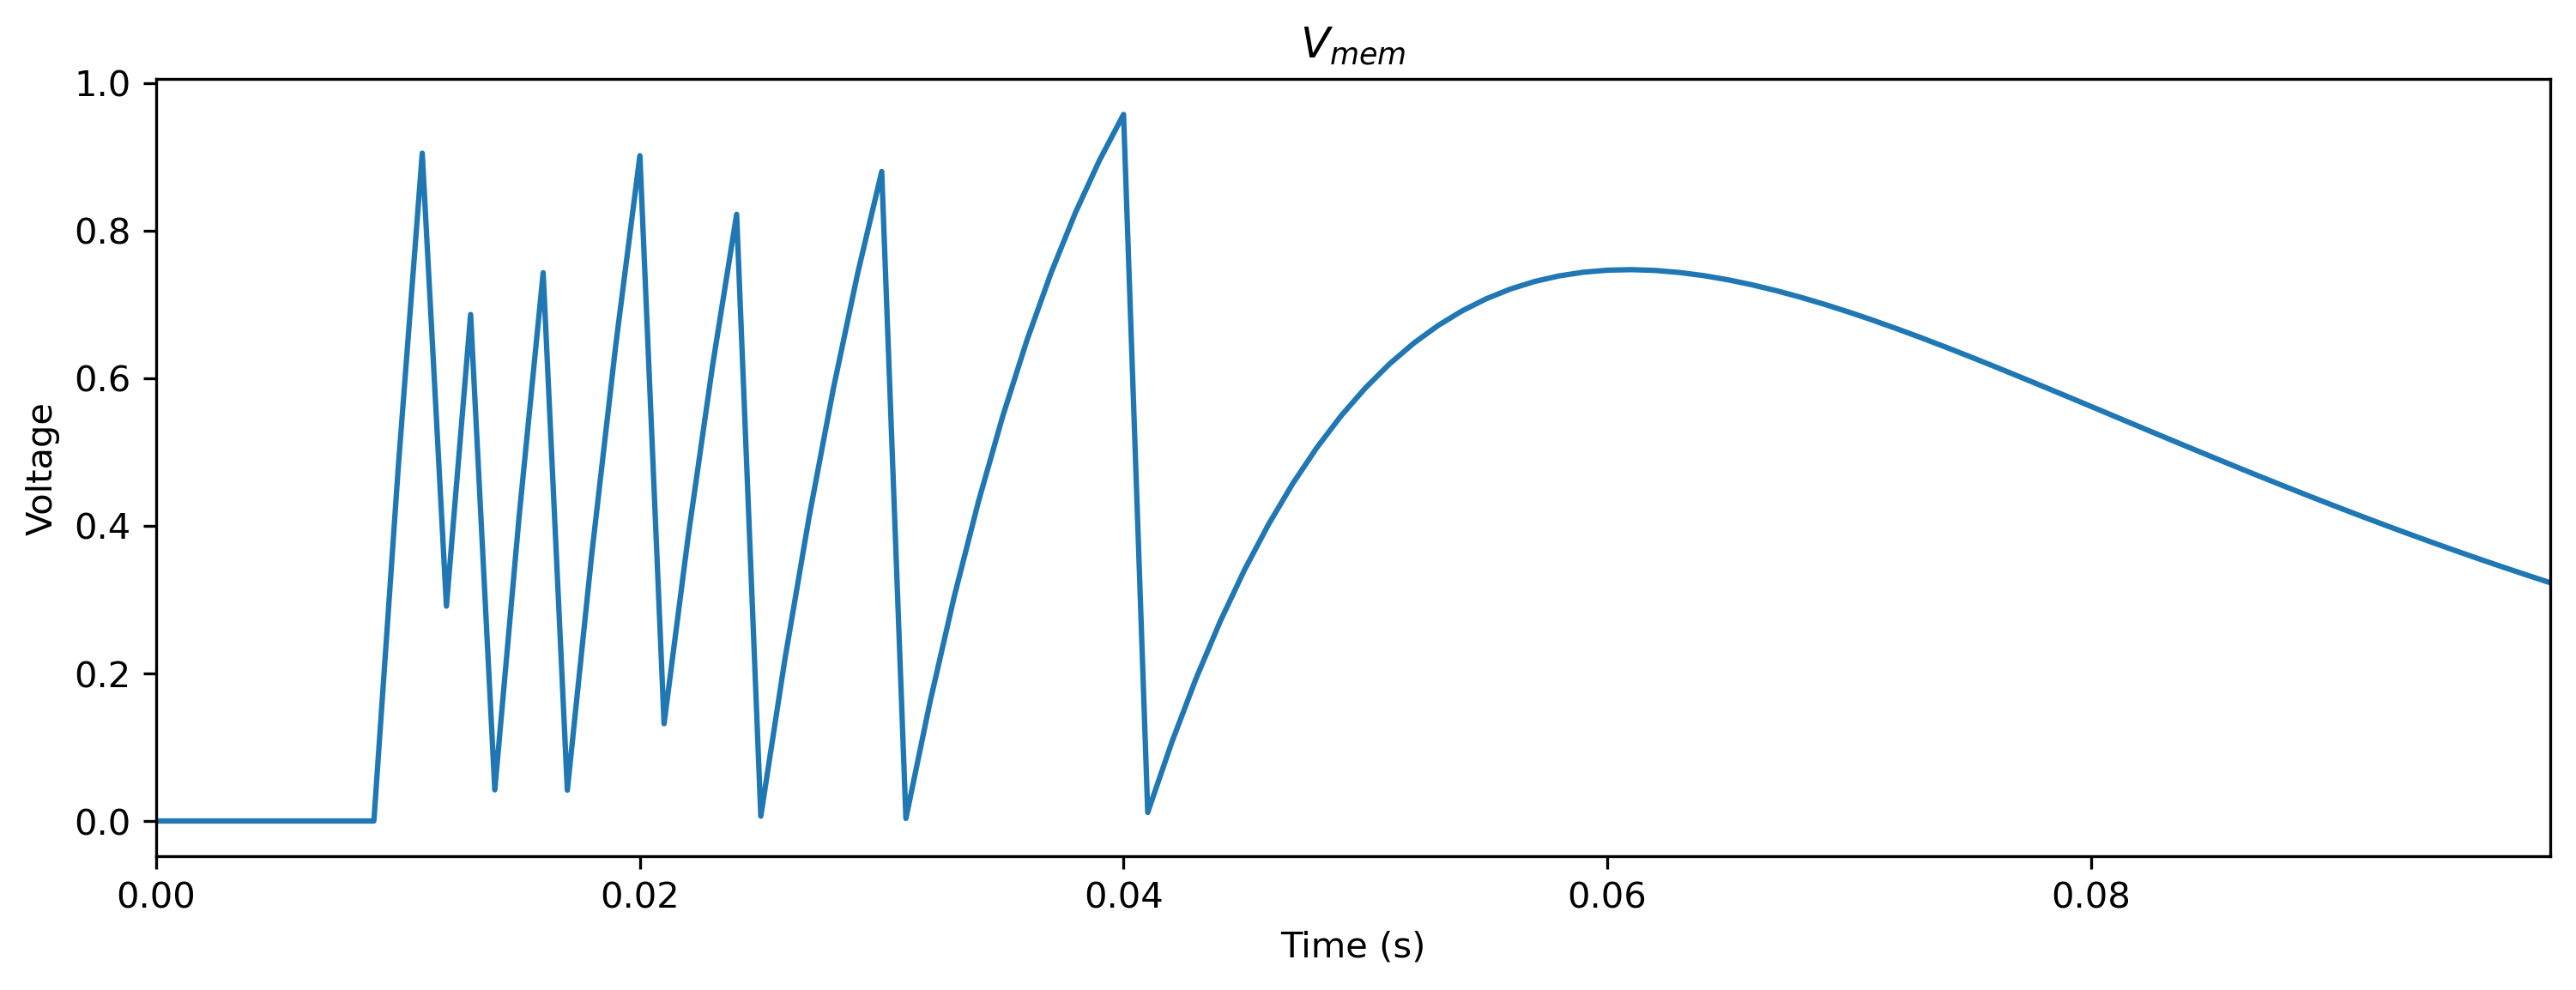

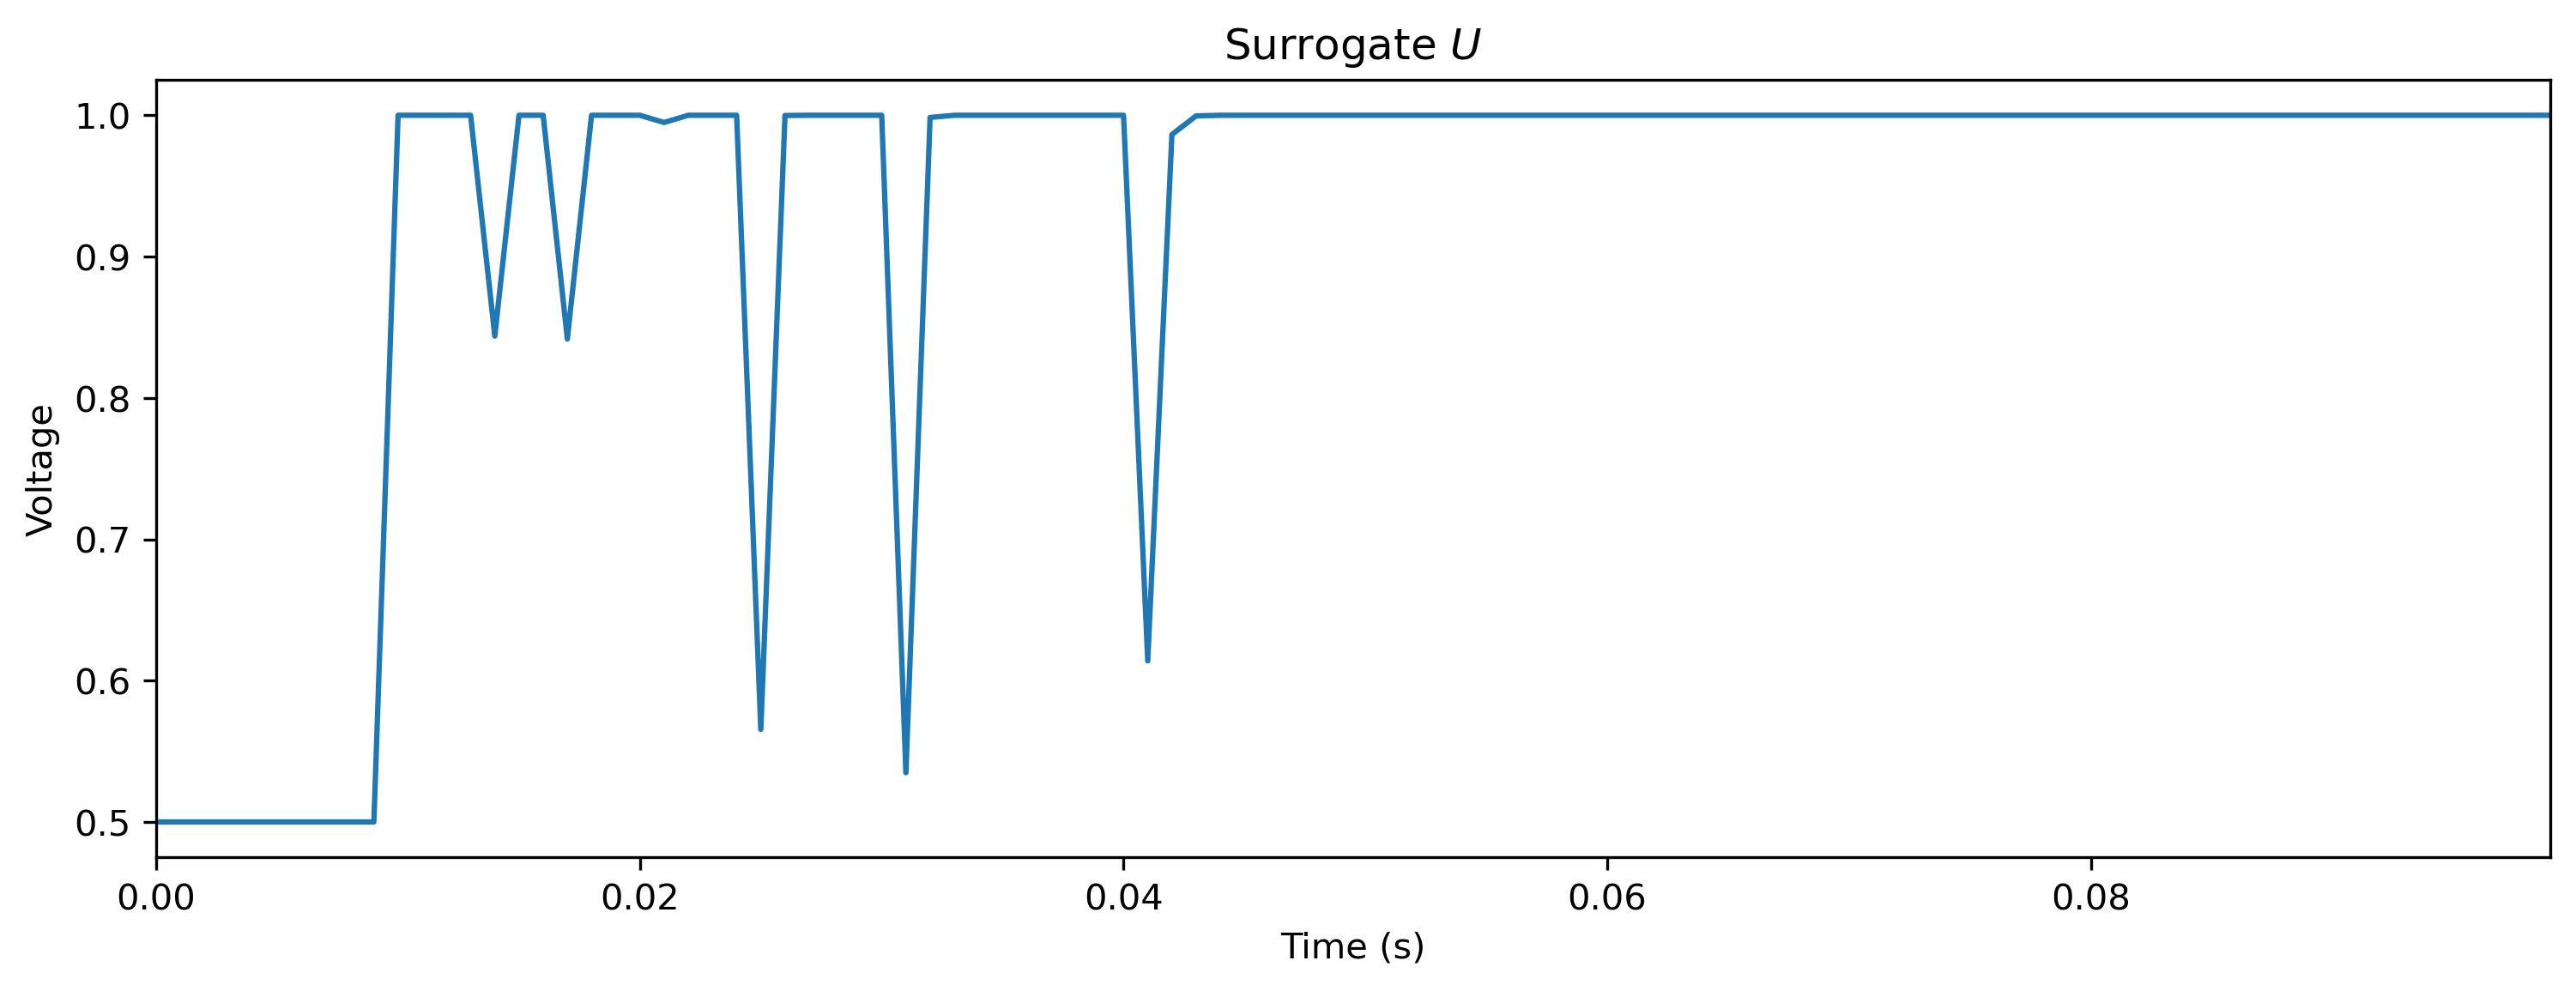

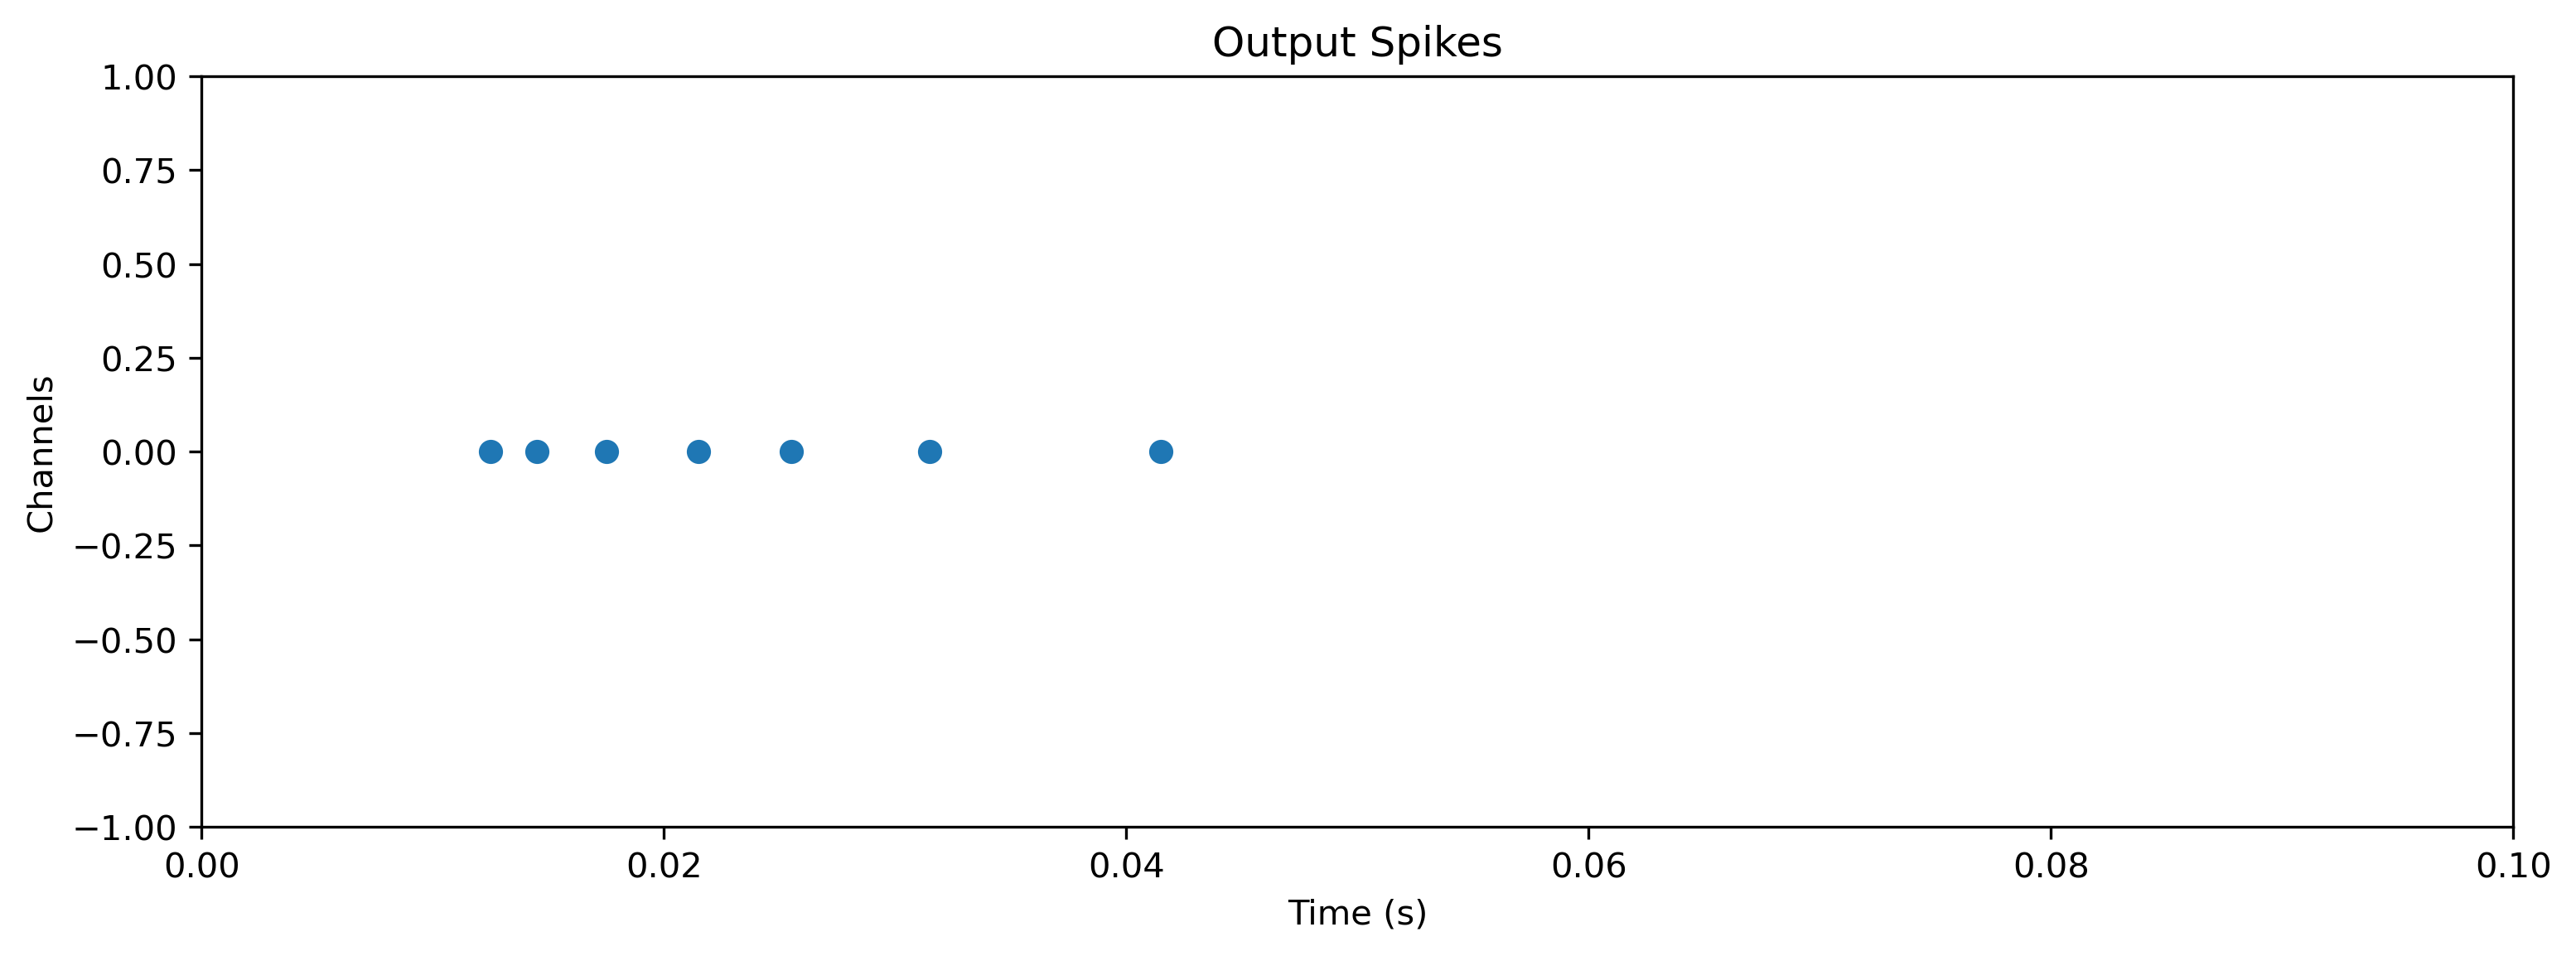

In [21]:
plot_LIF_record(record_dict_0['1_LIFTorch'], plot_Irec=True)

## Section 2: Surrogate Gradients

## Section 3: Define task and visualize data

In the next cell we have provided code to load the data and plot the input and target response.

### Spike Delay Task

In this very simple task, we want to produce an output spike a certain amount of timesteps after a single input spike. With this task, we can investigate the duration of temporal memory of our network (or neurons) by systematically increasing the delay between input and output spike.

For starters, we define a trial to be $100$ timesteps long and generate an input spike at $T_{stim} = 10$ and expect an output spike $T_{delay} = 20$ timesteps after the input. $T_{target} = T_{stim} + T_{delay}$

In [22]:
# inp = uniform_spike_rate(duration=100e-3, rate=100.0, dt=dt)
inp = poisson_spike_train(duration=100e-3, rate=200.0, dt=dt)
tgt = torch.tensor(50.0)

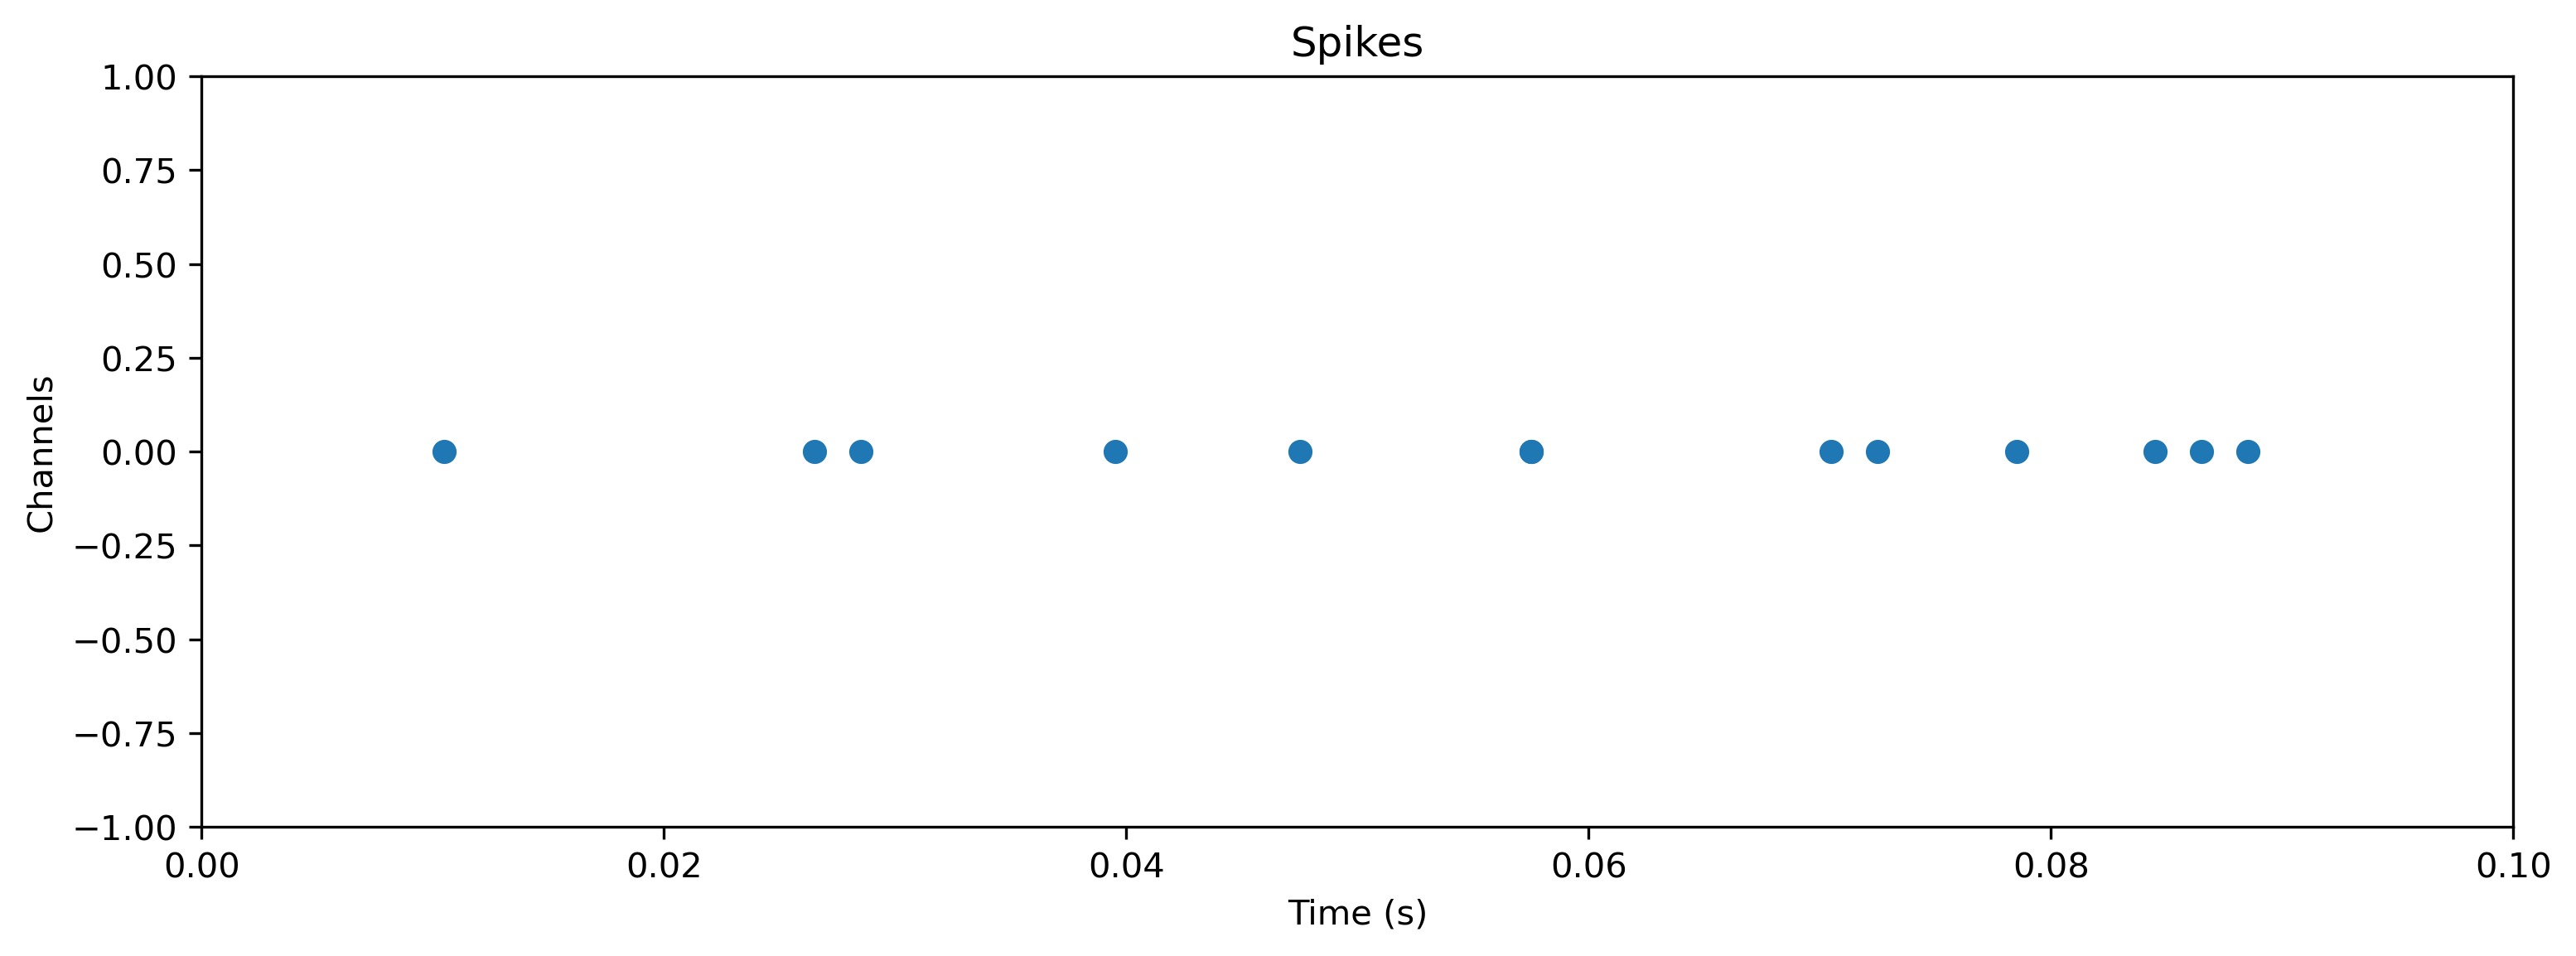

In [23]:
fig = plt.figure()
input_ts = TSEvent.from_raster(inp[0], dt=dt, name="Spikes")
input_ts.plot();


## Section 3 : Training a Spiking Neural Network

In [24]:
lin_0 = LinearTorch((1, 1), has_bias=False)

neuron_0 = LIFTorch((1, 1),
                  tau_mem=Constant(0.03),
                  tau_syn=Constant(0.03),
                  bias=Constant(0.),
                  threshold=Constant(1.),
                  spike_generation_fn=PeriodicExponential,
                  learning_window=100.,
                  dt=0.001)

readout_0 = RateReadout((1,1), dt= dt)

model = Sequential(lin_0, neuron_0, readout_0)


WARNING    /home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/nn/modules/torch/lif_torch.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_float_tensor = lambda x: torch.tensor(x).float()
 [py.warnings]


In [25]:
crit = nn.MSELoss()
optim = Adam(model.parameters().astorch(), lr=1e-1)
param_trace = []
loss_trace = []
grad_trace = []

for i in tqdm(range(1000)):
    model.reset_state()
    optim.zero_grad()
    out, state, rec = model.evolve(inp[0], record=True)
    
    loss = crit(tgt, out)
    loss_trace.append(loss.item())
    
    if loss == 0:
        break
        
    loss.backward()
    optim.step()
    
    param_trace.append(model._modules['0_LinearTorch'].weight.data[0, 0].item())
    grad_trace.append(model._modules['0_LinearTorch'].weight.grad[0, 0].item())

 18%|█▊        | 181/1000 [00:12<00:57, 14.16it/s]


## Section 4 : Analyzing the Results

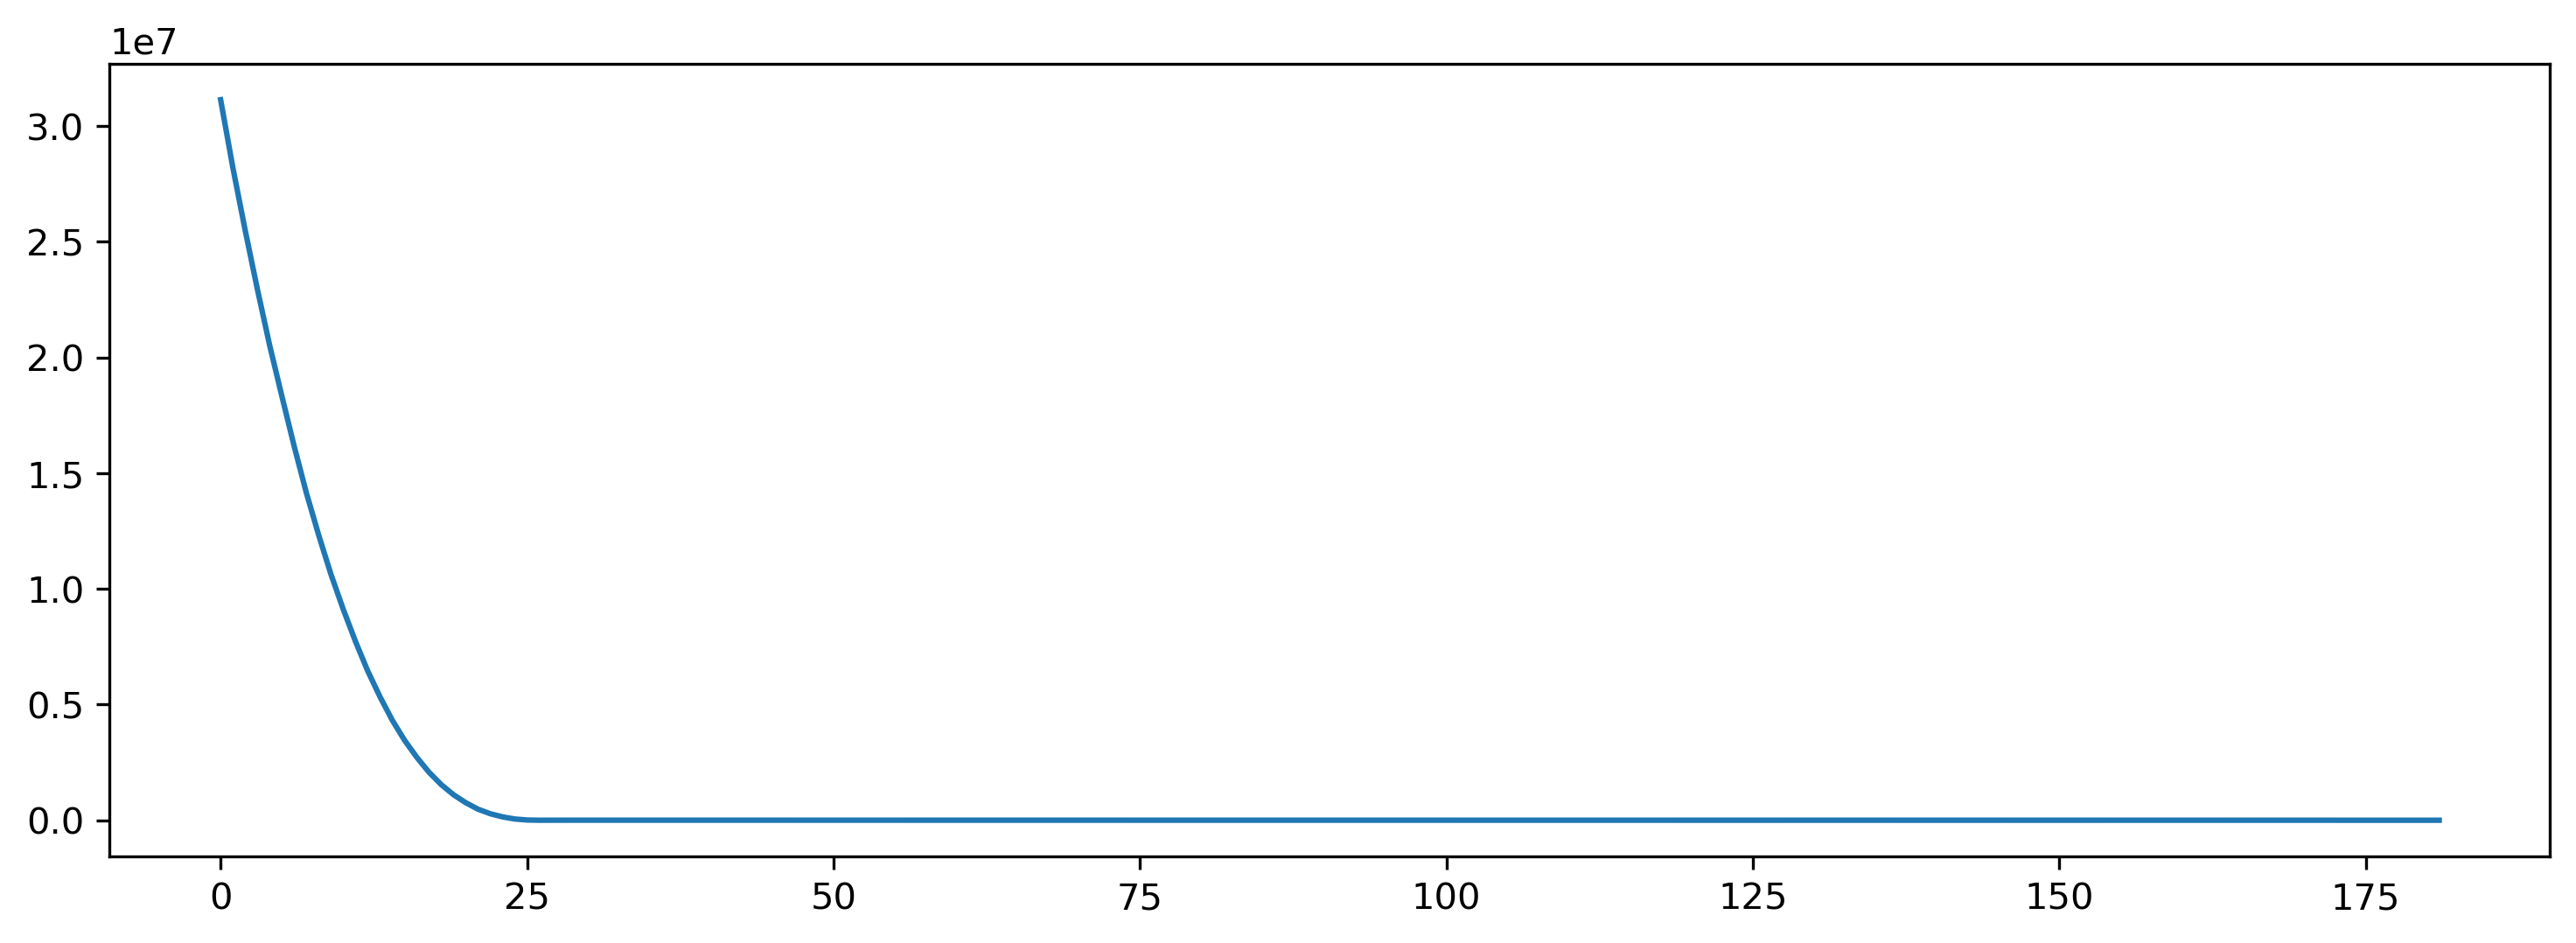

In [26]:
plt.plot(loss_trace)

In [27]:
modIn = model[0]
modLIF = model[1]

In [28]:
# Explore tau and weight change

In [29]:
model.reset_state()
out, state, rec = model(inp[0], record=True)

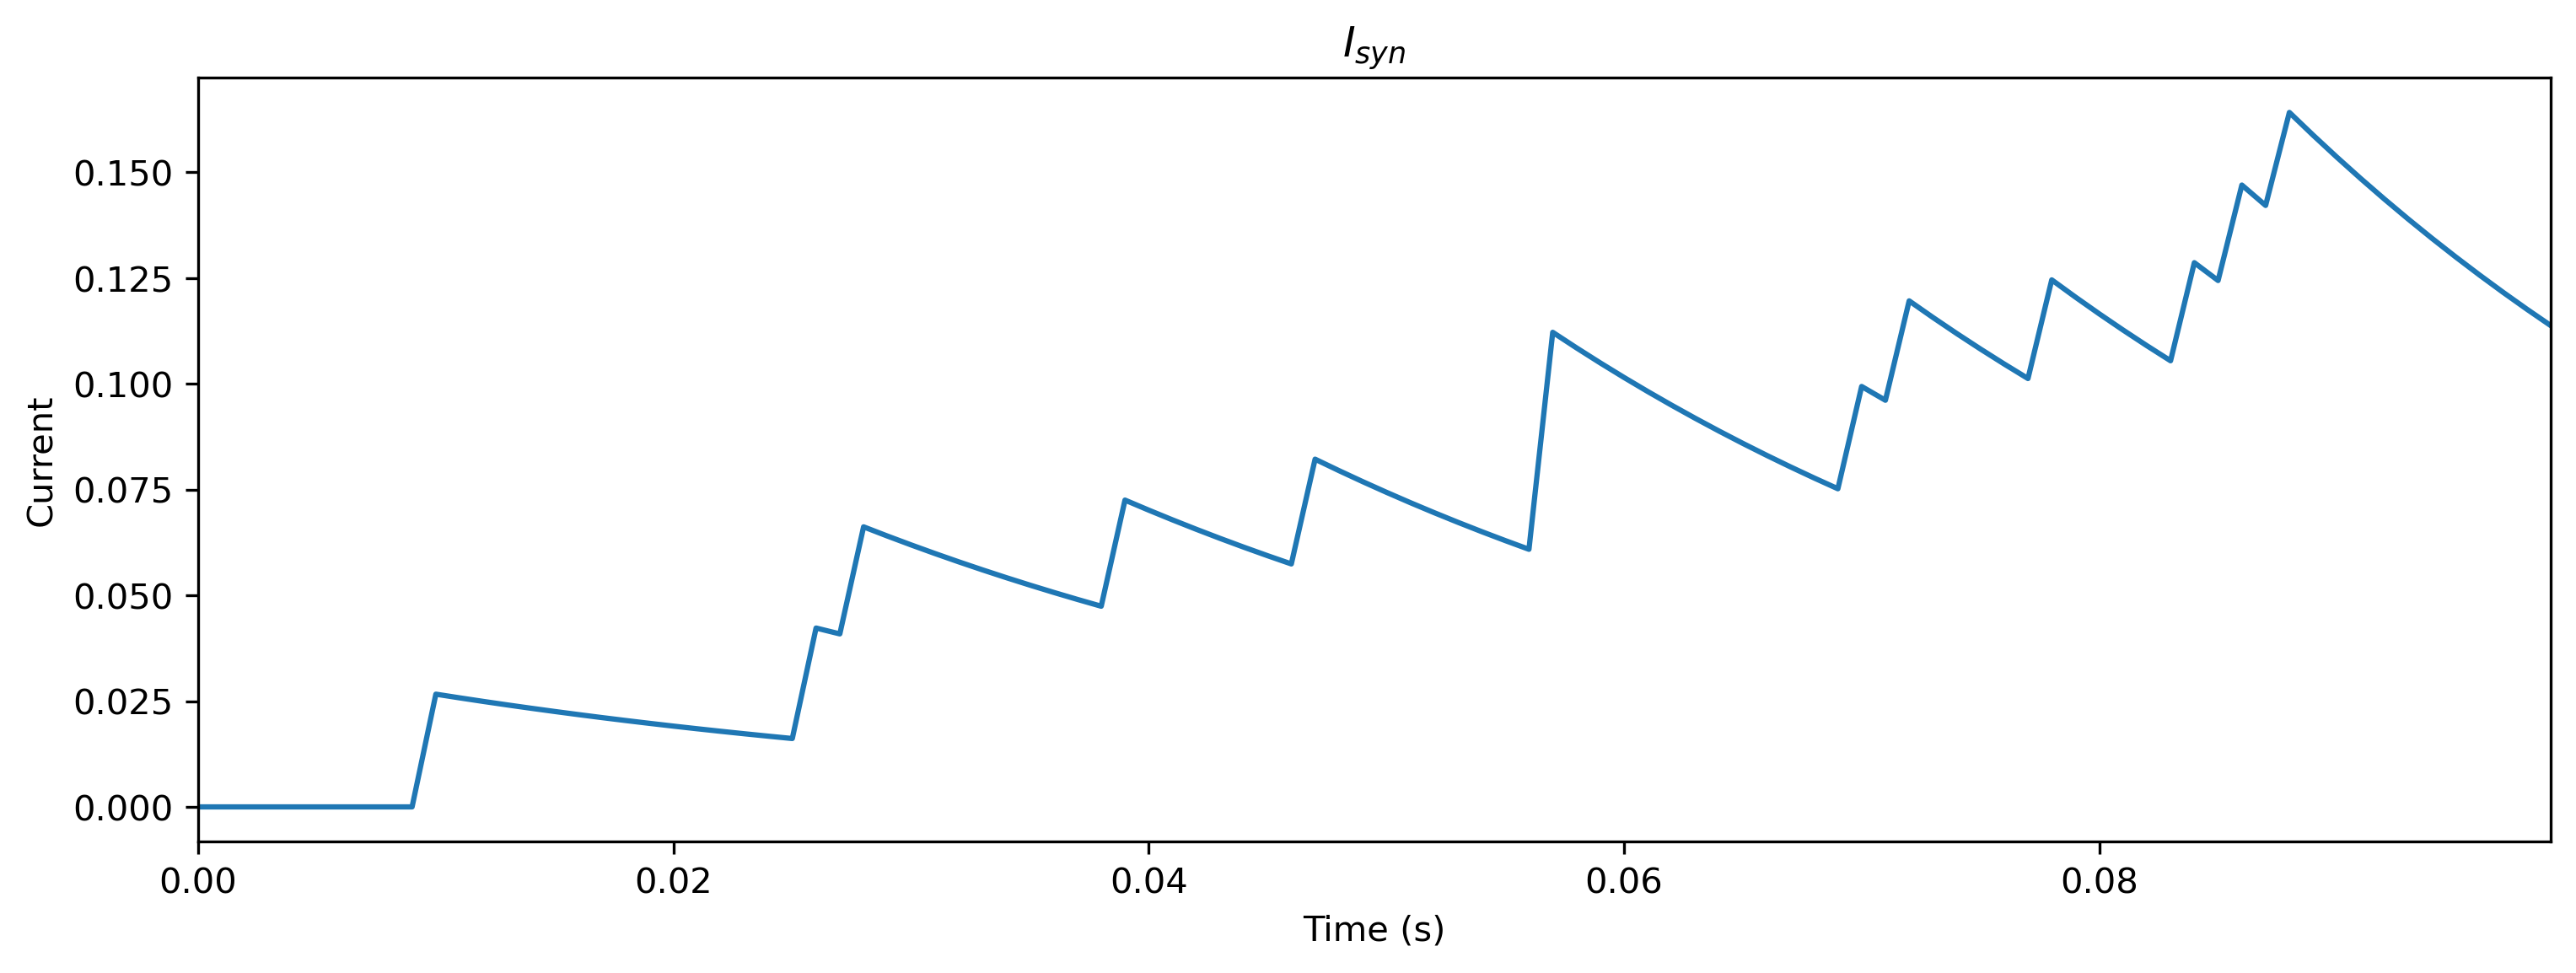

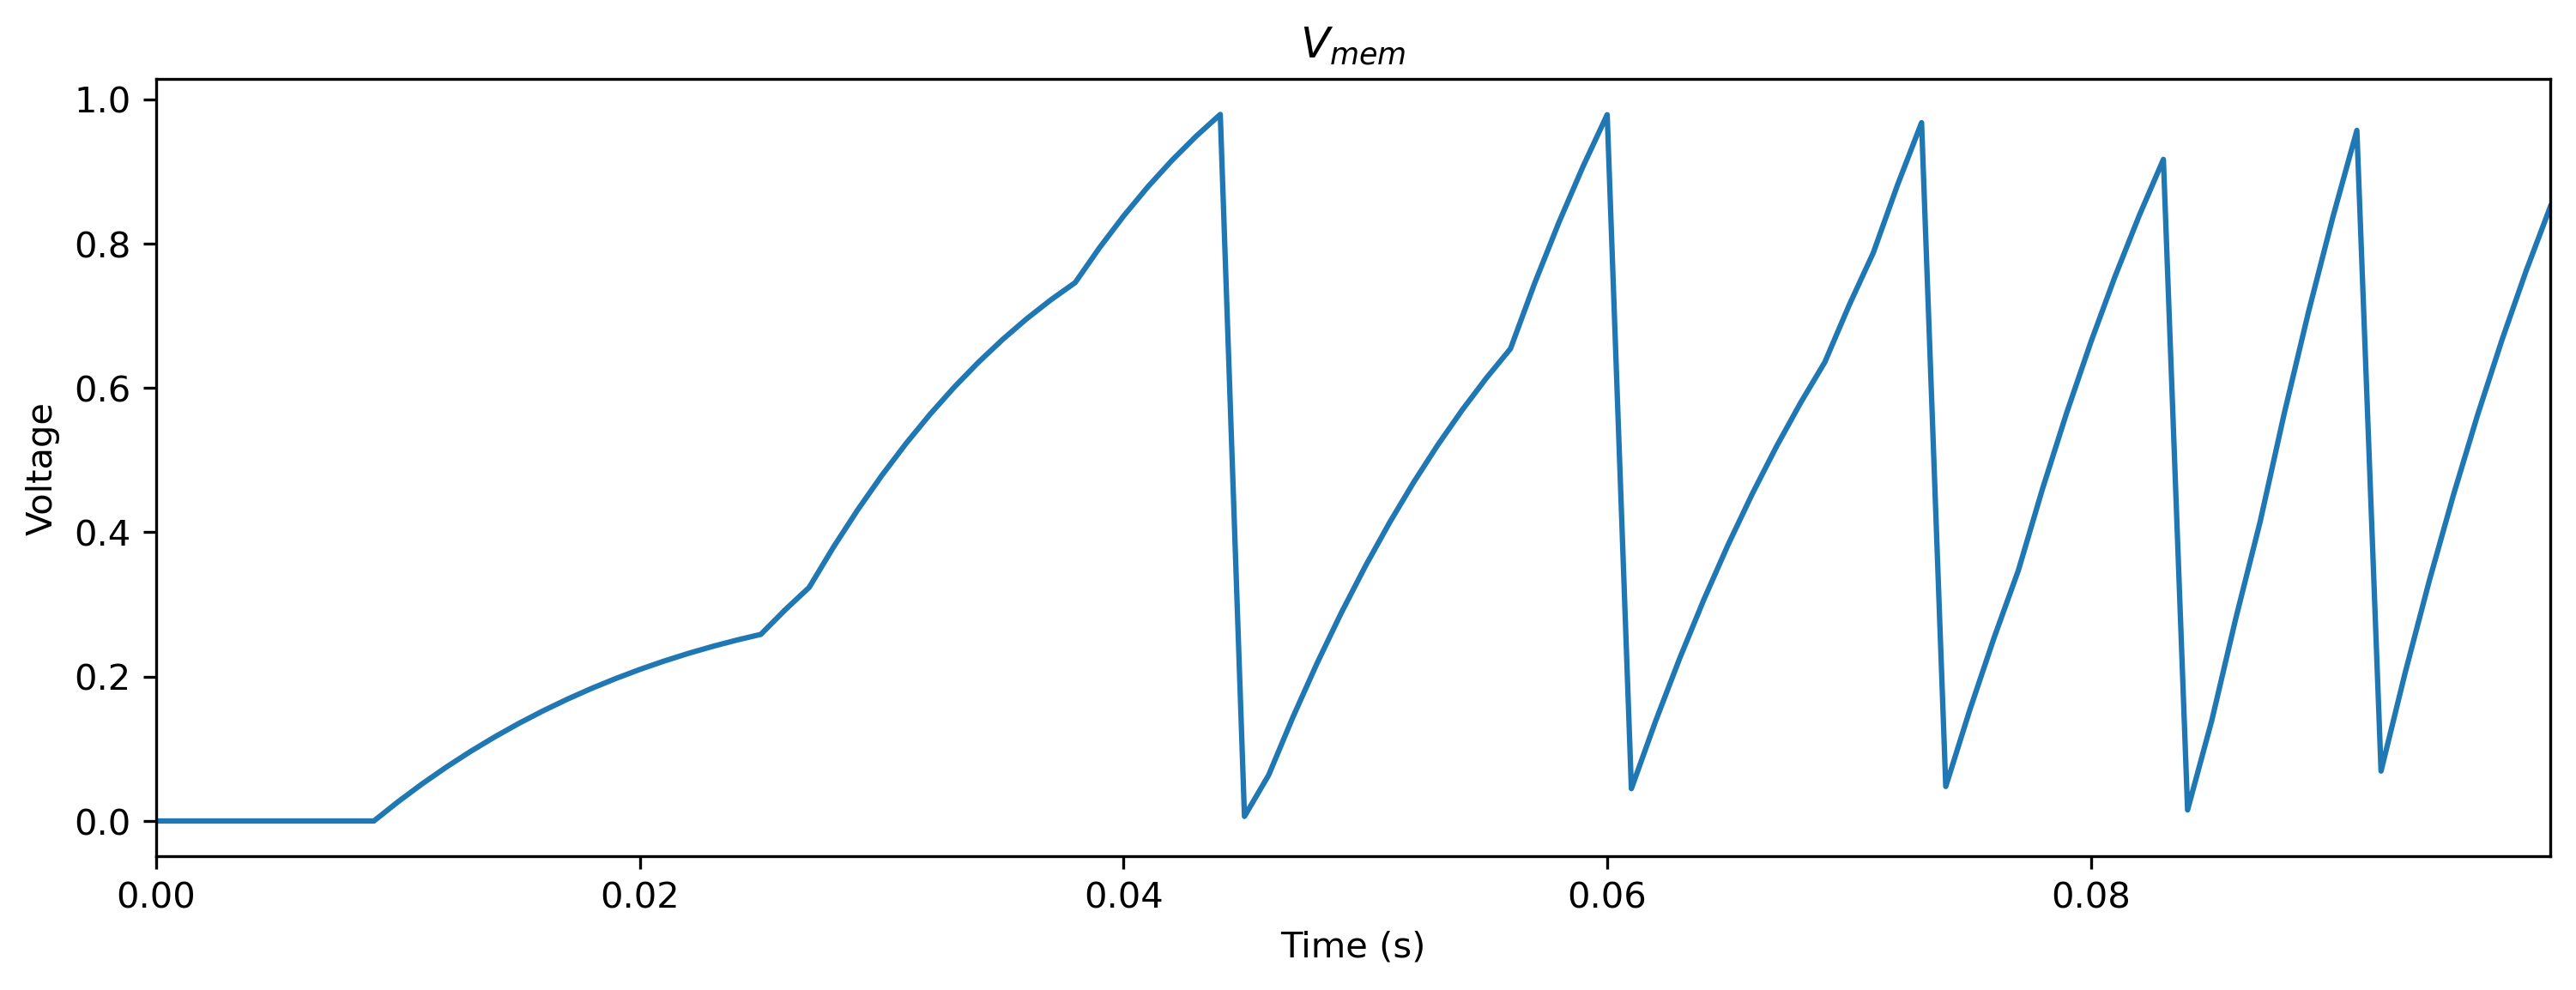

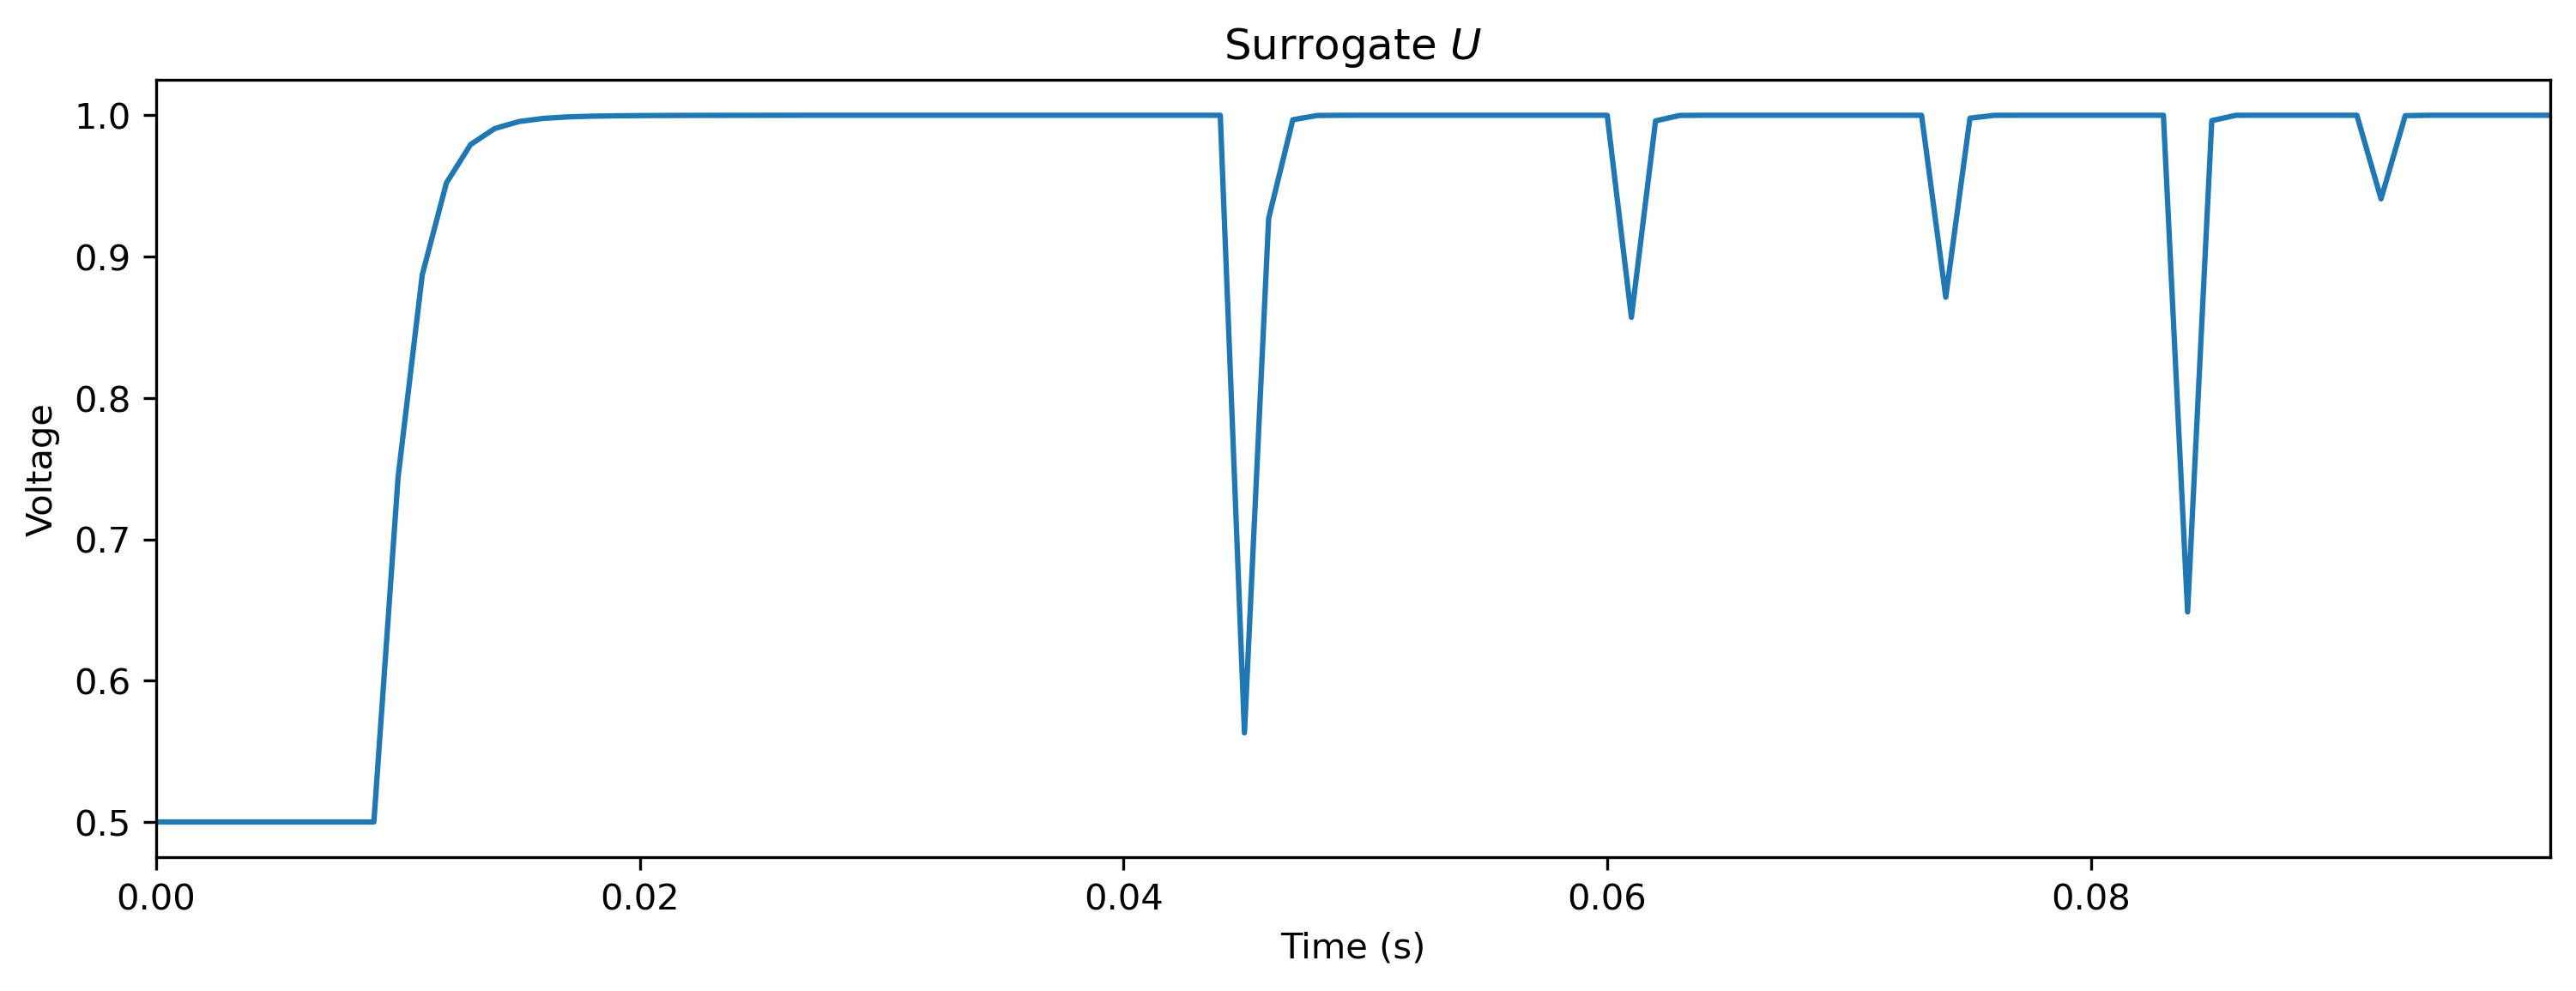

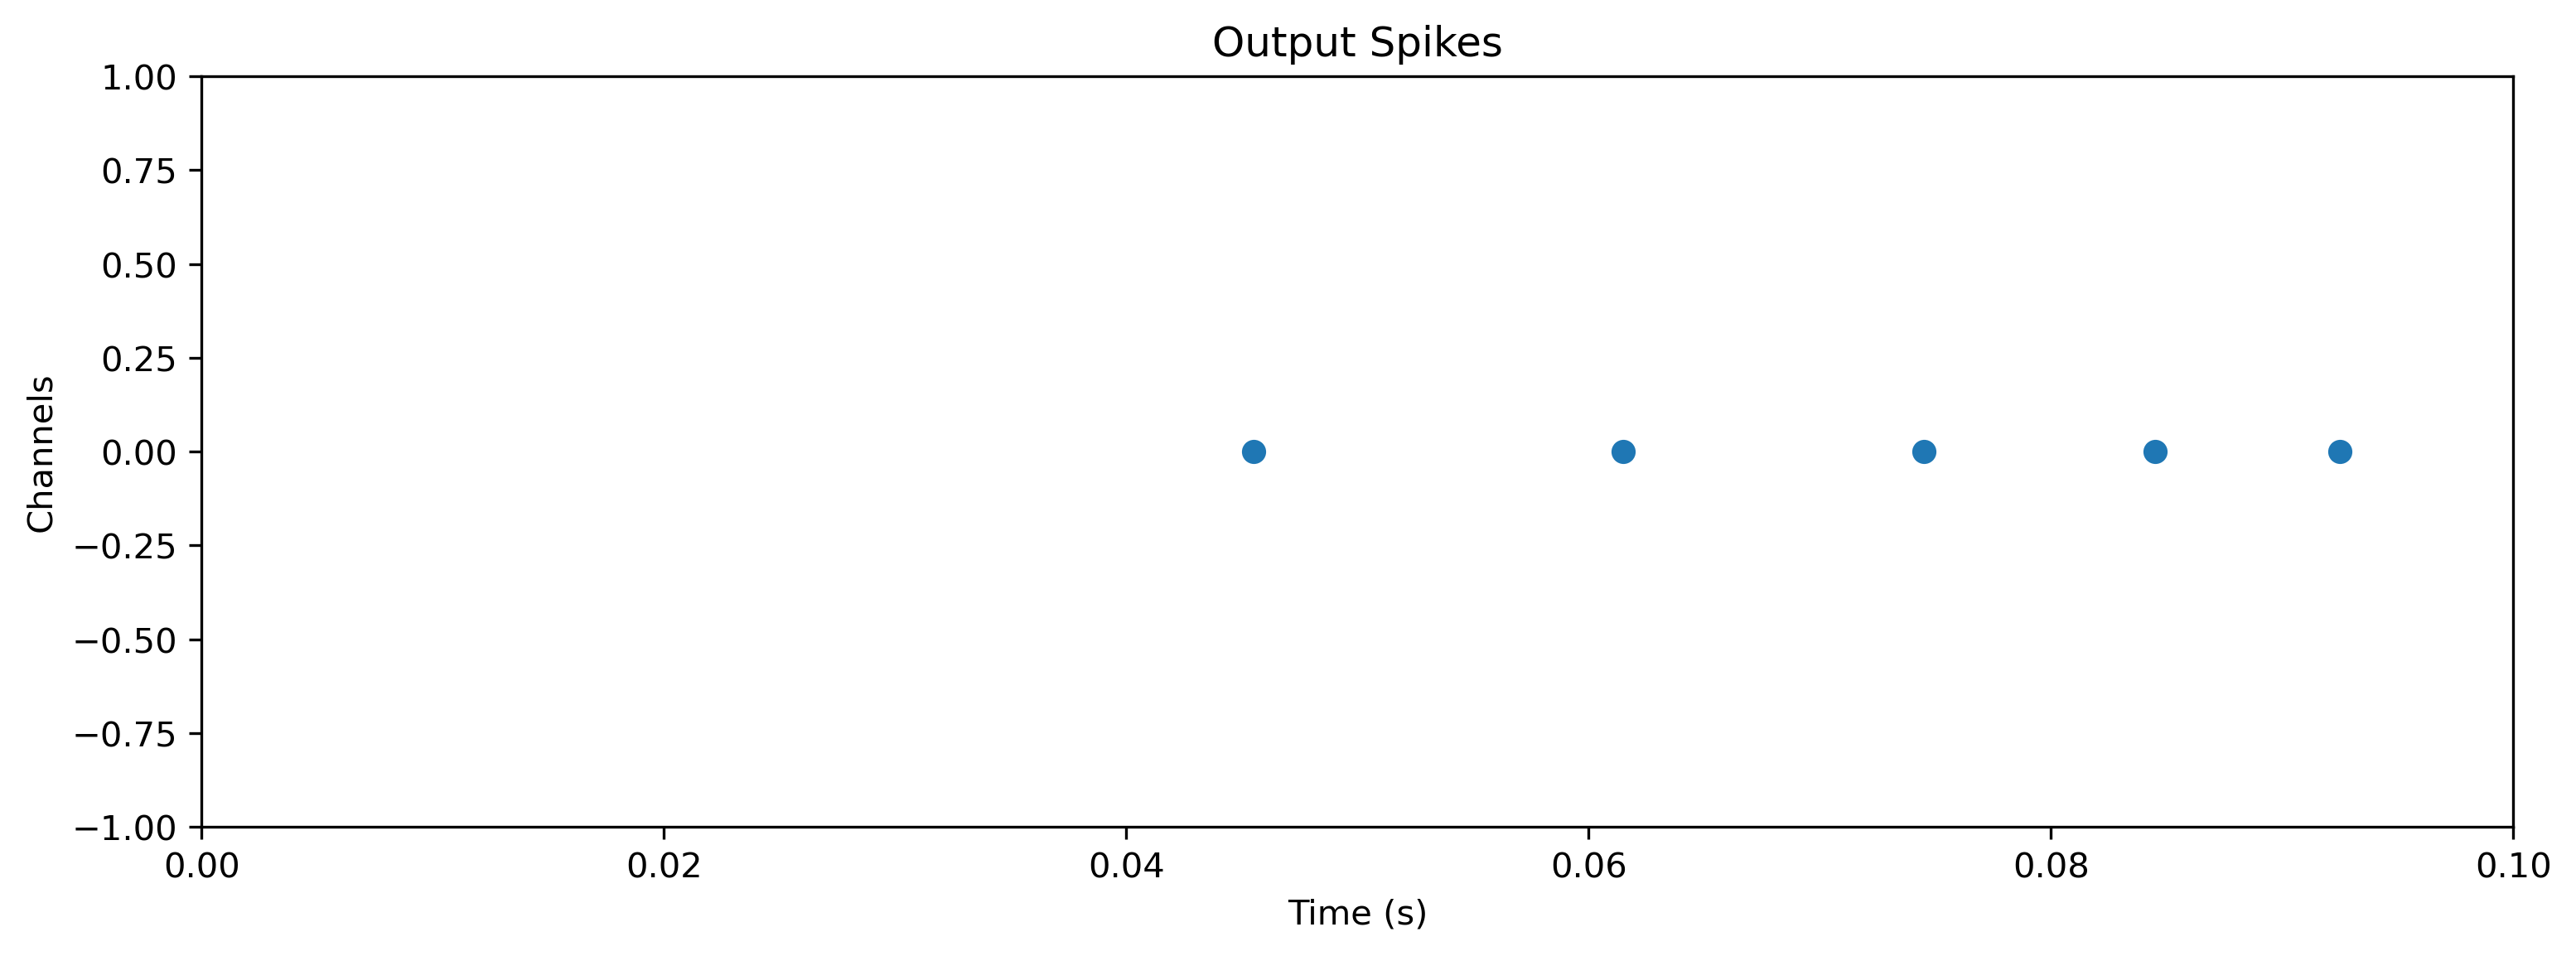

In [30]:
plot_LIF_record(rec['1_LIFTorch'])

Text(0.5, 0, 'epoch')

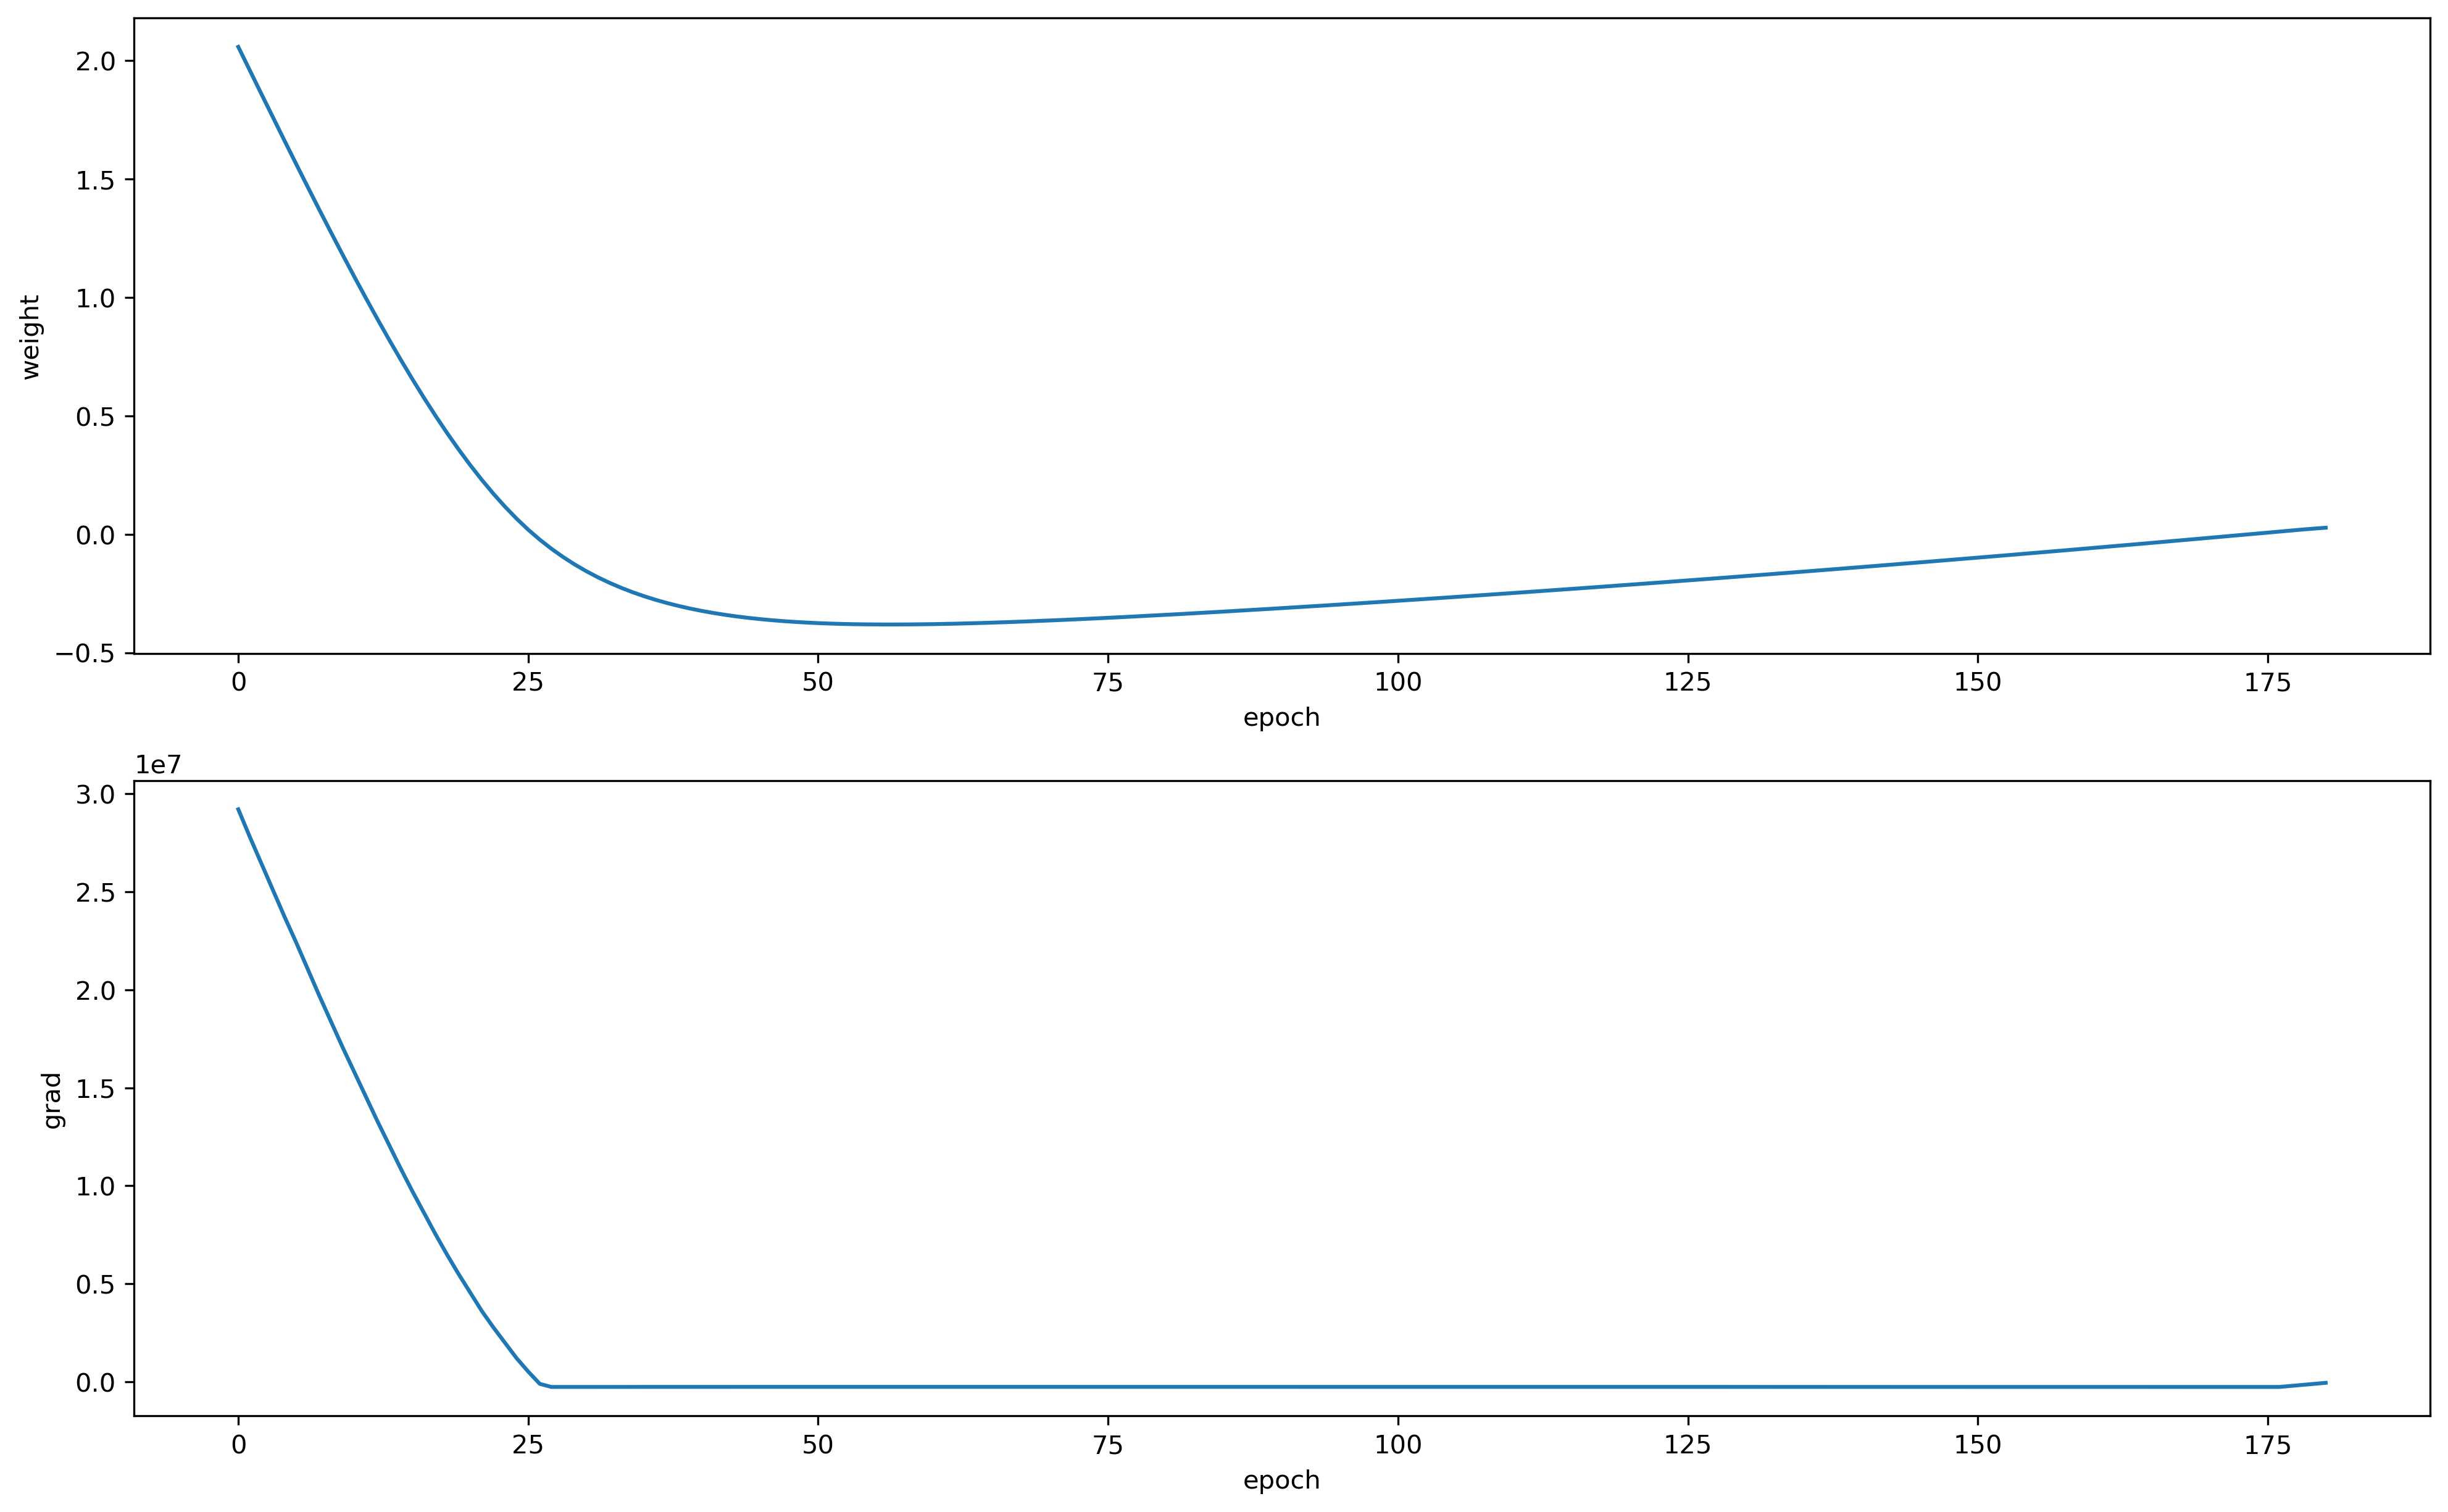

In [31]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(211)
plt.plot(param_trace)
plt.ylabel("weight")
plt.xlabel("epoch")
ax = fig.add_subplot(212)
plt.plot(grad_trace)
plt.ylabel("grad")
plt.xlabel("epoch")